 # What offensive trends can we find from a dataset of NFL rushing plays and how can we use this information to make better decisions as coaches and fans?

## Team Members:Drew A. Svoboda, Kaijie Cai, Ziyi Liu

In [ ]:
# Package Installations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import datetime
import tqdm
import re
from string import punctuation
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# neural net modules
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

from plotly.offline import iplot
from plotly import tools
import plotly.graph_objects as go
import plotly.express as px
import plotly.offline as py
import plotly.figure_factory as ff

# Data preparation

In [ ]:
# show the head of the dataset
df = pd.read_csv('/Users/jim/Downloads/train.csv')
df.head()

/var/folders/mc/_m07v67j0tv06gtjvr_bwgpr0000gn/T/ipykernel_19385/3032278647.py:2: DtypeWarning:

Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.



,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,...,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8.0,SW
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8.0,SW
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8.0,SW
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8.0,SW
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8.0,SW


## Data Description

In [ ]:
# check the shape of the data
df.shape

(682154, 49)

In [ ]:
# check the data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682154 entries, 0 to 682153
Data columns (total 49 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   GameId                  682154 non-null  int64  
 1   PlayId                  682154 non-null  int64  
 2   Team                    682154 non-null  object 
 3   X                       682154 non-null  float64
 4   Y                       682154 non-null  float64
 5   S                       682154 non-null  float64
 6   A                       682154 non-null  float64
 7   Dis                     682154 non-null  float64
 8   Orientation             682131 non-null  float64
 9   Dir                     682126 non-null  float64
 10  NflId                   682154 non-null  int64  
 11  DisplayName             682154 non-null  object 
 12  JerseyNumber            682154 non-null  int64  
 13  Season                  682154 non-null  int64  
 14  YardLine            

In [ ]:
# check the unique value for each columns
cat_features = []
for col in df.columns:
    if df[col].dtype =='object':
        cat_features.append((col, len(df[col].unique())))

cat_features

[('Team', 2),
 ('DisplayName', 2568),
 ('GameClock', 901),
 ('PossessionTeam', 32),
 ('FieldPosition', 33),
 ('OffenseFormation', 9),
 ('OffensePersonnel', 61),
 ('DefensePersonnel', 45),
 ('PlayDirection', 2),
 ('TimeHandoff', 30709),
 ('TimeSnap', 30721),
 ('PlayerHeight', 16),
 ('PlayerBirthDate', 1897),
 ('PlayerCollegeName', 314),
 ('Position', 25),
 ('HomeTeamAbbr', 32),
 ('VisitorTeamAbbr', 32),
 ('Stadium', 61),
 ('Location', 67),
 ('StadiumType', 34),
 ('Turf', 23),
 ('GameWeather', 74),
 ('WindSpeed', 70),
 ('WindDirection', 59)]

## Data Cleaning

### Dealing with variables

- **Team**: home or away

In [ ]:
def transform_Team(txt):
    if isinstance(txt, str):  # Check if the input is a string
        if 'home' in txt:
            return 1
        if 'away' in txt:
            return 0
    return np.nan

# create a new dummy variable for Turf
df['Team_dummy'] = df['Team'].apply(transform_Team)

# check the result
# 1 for home type and 0 for away type
df['Team_dummy'].value_counts()

Team_dummy
0    341077
1    341077
Name: count, dtype: int64

- **StadiumType**: There are 23 catagories in this 'StadiumType' column. We merged them into two: "outdoor" and "indoor"

In [ ]:
df['StadiumType'].unique()

array(['Outdoor', 'Outdoors', 'Indoors', 'Retractable Roof', 'Indoor',
       'Retr. Roof-Closed', 'Open', nan, 'Indoor, Open Roof',
       'Retr. Roof - Closed', 'Outddors', 'Dome', 'Domed, closed',
       'Indoor, Roof Closed', 'Retr. Roof Closed',
       'Outdoor Retr Roof-Open', 'Closed Dome', 'Oudoor', 'Ourdoor',
       'Dome, closed', 'Retr. Roof-Open', 'Heinz Field', 'Outdor',
       'Retr. Roof - Open', 'Domed, Open', 'Domed, open', 'Cloudy',
       'Bowl', 'Outside', 'Domed', 'Indoor, roof open', 'indoor',
       'Retractable Roof - Closed', 'OUTDOOR'], dtype=object)

In [ ]:
# from https://www.kaggle.com/code/bgmello/neural-networks-feature-engineering-for-the-win

def clean_StadiumType(txt):
    if pd.isna(txt):
        return np.nan
    txt = txt.lower()
    txt = ''.join([c for c in txt if c not in punctuation])
    txt = re.sub(' +', ' ', txt)
    txt = txt.strip()
    txt = txt.replace('outside', 'outdoor')
    txt = txt.replace('outdor', 'outdoor')
    txt = txt.replace('outddors', 'outdoor')
    txt = txt.replace('outdoors', 'outdoor')
    txt = txt.replace('oudoor', 'outdoor')
    txt = txt.replace('indoors', 'indoor')
    txt = txt.replace('ourdoor', 'outdoor')
    txt = txt.replace('retractable', 'rtr.')
    return txt

df['StadiumType'] = df['StadiumType'].apply(clean_StadiumType)

In [ ]:
def transform_StadiumType(txt):
    if pd.isna(txt):
        return np.nan
    if 'outdoor' in txt or 'open' in txt :
        return 1
    if 'indoor' in txt or 'closed' in txt :
        return 0

    return np.nan

df['StadiumType'] = df['StadiumType'].apply(transform_StadiumType)

# check the result
# 1 for outdoor type and 0 for indoor type
df['StadiumType'].value_counts()

StadiumType
1.0    484286
0.0    109824
Name: count, dtype: int64

- **Turf**: about description of the field surface. We merged catagories into two: "Natural" and "Artificial"

In [ ]:
df['Turf'].value_counts()

Turf
Grass                     221342
Natural Grass             142560
Field Turf                 64306
Artificial                 57772
FieldTurf                  47146
UBU Speed Series-S5-M      42394
A-Turf Titan               23210
SISGrass                   13662
Natural grass               9262
UBU Sports Speed S5-M       8558
FieldTurf360                8272
DD GrassMaster              8074
Twenty-Four/Seven Turf      8030
Artifical                   7018
FieldTurf 360               6974
Twenty Four/Seven Turf      5654
Turf                        1980
Natural                     1628
Field turf                   990
Naturall Grass               858
UBU-Speed Series-S5-M        836
natural grass                814
grass                        814
Name: count, dtype: int64

In [ ]:
def transform_Turf(txt):
    if isinstance(txt, str):  # Check if the input is a string
        if 'Natural' in txt:
            return 1
        if 'Artificial' in txt:
            return 0
    return np.nan

# create a new dummy variable for Turf
df['Turf_dummy'] = df['Turf'].apply(transform_Turf)

# check the result
# 1 for Natural type and 0 for Artificial type
df['Turf_dummy'].value_counts()

Turf_dummy
1.0    154308
0.0     57772
Name: count, dtype: int64

- **WindSpeed**: data cleaning for this column

In [ ]:
df['WindSpeed'].value_counts()
# Here we could see, this column is messy, wecan't use it directly.
# So, we need to move 'mph' from ''WindSpeed' columns

WindSpeed
5        36102
5.0      30162
7.0      27544
6.0      26540
7        24750
         ...  
22         836
SSE        836
9mph       792
11-17      726
19         660
Name: count, Length: 69, dtype: int64

In [ ]:
df['WindSpeed'] = df['WindSpeed'].apply(lambda x: x.lower().replace('mph', '').strip() if isinstance(x, str) else x)

# check the result
df['WindSpeed'].value_counts()

WindSpeed
5                    36102
5.0                  30162
7.0                  27544
6.0                  26540
7                    25850
6                    25402
10                   23400
3                    22912
10.0                 22360
9.0                  22164
4                    21376
4                    21216
2.0                  20360
8.0                  20306
12.0                 20016
8                    18634
9                    18404
11.0                 18060
3                    17040
12                   12500
2                    12420
13                   11132
1                     9416
15                    9130
15.0                  8932
13                    8294
0.0                   8008
0                     7656
1                     6292
16.0                  5962
11                    5810
16                    5016
14.0                  4154
14                    3700
17                    3674
17.0                  3212
18.0              

In [ ]:
# Some rows are 12-22 or 14-23
# Let's replace the ones that has x-y by (x+y)/2
# and also the ones with x gusts up to y
df['WindSpeed'] = df['WindSpeed'].apply(lambda x: (int(x.split('-')[0]) + int(x.split('-')[1])) / 2 if isinstance(x, str) and '-' in x else x)
df['WindSpeed'] = df['WindSpeed'].apply(lambda x: (int(x.split()[0]) + int(x.split()[-1])) / 2 if isinstance(x, str) and 'gusts up to' in x else x)

df['WindSpeed'] = pd.to_numeric(df['WindSpeed'], errors='coerce')
df['WindSpeed'].value_counts()

WindSpeed
5.0     66264
7.0     53394
6.0     51942
10.0    45760
4.0     42592
9.0     40568
3.0     39952
8.0     38940
2.0     32780
12.0    32516
11.0    23870
13.0    19426
15.0    19162
1.0     15708
0.0     15664
16.0    10978
14.0     8580
17.0     7942
18.0     3102
20.0     2926
23.0     2156
19.0     1826
18.5      968
24.0      968
22.0      836
Name: count, dtype: int64

- **WindDirection**: convert into 8 primary wind directions (N, NE, E, SE, S, SW, W, NW).

In [ ]:
# check the unique categories of this column
df['WindDirection'].unique()

array(['SW', 'NNE', 'SE', 'East', nan, 'NE', 'North', 'S', 'Northwest',
       'SouthWest', 'ENE', 'ESE', 'SSW', 'NW', 'Northeast', 'From S', 'W',
       'South', 'West-Southwest', 'E', '13', 'N', 'NNW',
       'South Southeast', 'SSE', 'West', 'WSW', 'From SW', 'WNW', 's',
       'NorthEast', 'from W', 'W-NW', 'South Southwest', 'Southeast',
       'From WSW', 'West Northwest', 'Calm', 'From SSE', 'From W',
       'East North East', 'From ESE', 'EAST', 'East Southeast',
       'From SSW', '8', 'North East', 'Southwest', 'North/Northwest',
       'From NNE', '1', 'N-NE', 'W-SW', 'From NNW', 'S-SW', 'From NE',
       'South west', 'South, Southeast', 'Southerly'], dtype=object)

In [ ]:
# Mapping Dictionary
direction_map = {
    'N': 'N', 'NNW': 'N', 'NNE': 'NE', 'North': 'N', 'Northwest': 'NW', 'North/Northwest': 'N', 'N-NE': 'NE',
    'NE': 'NE', 'ENE': 'NE', 'Northeast': 'NE', 'NorthEast': 'NE', 'North East': 'NE', 'From NNE': 'NE', 'East North East': 'NE',
    'E': 'E', 'ENE': 'NE', 'ESE': 'SE', 'East': 'E', 'East Southeast': 'SE', 'EAST': 'E', 'From ESE': 'SE', 's': 'Unknown',
    'SE': 'SE', 'SSE': 'SE', 'ESE': 'SE', 'Southeast': 'SE', 'South Southeast': 'SE', 'South, Southeast': 'SE', 'From SSE': 'SE',
    'S': 'S', 'SSW': 'SW', 'SSE': 'SE', 'South': 'S', 'Southerly': 'S', 'South west': 'SW', 'From S': 'S', 'From SSW': 'SW',
    'SW': 'SW', 'SSW': 'SW', 'WSW': 'SW', 'Southwest': 'SW', 'South West': 'SW', 'SouthWest': 'SW', 'West-Southwest': 'SW', 'W-SW': 'SW', 'S-SW': 'SW', 'From SW': 'SW',
    'W': 'W', 'WNW': 'NW', 'WSW': 'W', 'West': 'W', 'West Northwest': 'NW', 'West-Southwest': 'SW', 'W-NW': 'NW', 'From W': 'W', 'From WSW': 'SW', 'from W': 'W',
    'NW': 'NW', 'NNW': 'NW', 'WNW': 'NW', 'Northwest': 'NW', 'North/Northwest': 'NW',
    # Special cases
    'Calm': 'Calm', '8': 'Calm', '1': 'Calm', '13': 'Calm', 'Unknown': 'Calm', 'nan': 'Calm'
}

# Apply the mapping
df['WindDirection'] = df['WindDirection'].map(direction_map).fillna('Calm')

df['WindDirection'] = df['WindDirection'].map(direction_map).fillna('Calm')
# It may be necessary to run it twice if the unknow value does not change.
# So, to avoid this problem, I'm using two lines of code that are identical.

# here we could change the null value to calm

# Check the result
print(df['WindDirection'].value_counts())

WindDirection
Calm    115984
NE       93896
NW       92862
SW       85822
W        85448
SE       65780
S        58058
N        50886
E        33418
Name: count, dtype: int64


In [ ]:
# visulization about wind in season 2017
# code from https://www.kaggle.com/code/pradeepmuniasamy/extensive-eda-fe-models-on-nfl-big-data-bowl

temp_df=df.loc[df.Season==2017]
temp_df=temp_df.drop_duplicates('GameId', keep='last')
temp_df=temp_df[["WindSpeed","WindDirection"]]
temp_df=temp_df.dropna()
fig = px.bar_polar(temp_df.loc[temp_df['WindDirection'] != "Calm"], r="WindSpeed", theta="WindDirection",
                   color="WindSpeed", template="plotly_dark",
                   category_orders= {"WindDirection":['N','NE','E','SE','S','SW','W']},
                   color_discrete_sequence= px.colors.sequential.Plasma[-2::-1])
fig.show()

In [ ]:
# Create a label encoder object
label_encoder = LabelEncoder()
# Fit the label encoder to your data
df['WindDirection_label'] = label_encoder.fit_transform(df['WindDirection'])

# check the result
df['WindDirection_label'].value_counts()

WindDirection_label
0    115984
3     93896
4     92862
7     85822
8     85448
6     65780
5     58058
2     50886
1     33418
Name: count, dtype: int64

- **Possession Team**: recode to 1 if it is same as the 'HomeTeamAbbr'

When a home player possesses the ball, the atmosphere of the home stadium gives the player confidence, which may have an impact on the offense's success.

If 'Possession Team' is the same as 'HomeTeamAbbr', recode the value to 1; otherwise, recode the value to 0.

In [ ]:
df['Possesion_Team_New'] = (df['PossessionTeam'] == df['HomeTeamAbbr']).astype(int)

df['Possesion_Team_New'].value_counts()

Possesion_Team_New
0    380974
1    301180
Name: count, dtype: int64

- **GameWeather**: encode to the weather map

climate controlled or indoor => 3, sunny or sun => 2, clear => 1, cloudy => -1, rain => -2, snow => -3, others => 0

In [ ]:
df['GameWeather'].unique()

array(['Clear and warm', 'Sun & clouds', 'Sunny', 'Controlled Climate',
       'Mostly Sunny', 'Clear', nan, 'Indoor', 'Mostly Cloudy',
       'Mostly Coudy', 'Partly sunny', 'Partly Cloudy', 'Cloudy',
       'Sunny, highs to upper 80s', 'Indoors', 'Light Rain', 'Showers',
       'Partly cloudy', 'Partly Sunny', '30% Chance of Rain',
       'Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
       'Rain', 'Cloudy, fog started developing in 2nd quarter', 'Coudy',
       'Rain likely, temps in low 40s.', 'Cold', 'N/A (Indoors)',
       'Clear skies', 'cloudy', 'Fair', 'Mostly cloudy',
       'Cloudy, chance of rain', 'Heavy lake effect snow', 'Party Cloudy',
       'Cloudy, light snow accumulating 1-3"', 'Cloudy and cold', 'Snow',
       'Hazy', 'Scattered Showers', 'Cloudy and Cool', 'N/A Indoor',
       'Rain Chance 40%', 'Clear and sunny', 'Mostly sunny',
       'Sunny and warm', 'Partly clear', 'Cloudy, 50% change of rain',
       'Clear and Sunny', '

In [ ]:
df['GameWeather'] = df['GameWeather'].str.lower()
indoor = "indoor"
df['GameWeather'] = df['GameWeather'].apply(lambda x: indoor if not pd.isna(x) and indoor in x else x)
df['GameWeather'] = df['GameWeather'].apply(lambda x: x.replace('coudy', 'cloudy').replace('clouidy', 'cloudy').replace('party', 'partly') if not pd.isna(x) else x)
df['GameWeather'] = df['GameWeather'].apply(lambda x: x.replace('clear and sunny', 'sunny and clear') if not pd.isna(x) else x)
df['GameWeather'] = df['GameWeather'].apply(lambda x: x.replace('skies', '').replace("mostly", "").strip() if not pd.isna(x) else x)

# look at the most common words we have in the weather description

from collections import Counter
weather_count = Counter()
for weather in df['GameWeather']:
    if pd.isna(weather):
        continue
    for word in weather.split():
        weather_count[word]+=1

weather_count.most_common()[:15]

[('cloudy', 252010),
 ('sunny', 180664),
 ('partly', 73216),
 ('clear', 71500),
 ('rain', 39116),
 ('indoor', 33352),
 ('controlled', 15708),
 ('climate', 15708),
 ('and', 14916),
 ('fair', 9966),
 ('cold', 5544),
 ('light', 5390),
 ('cloudy,', 4972),
 ('snow', 4708),
 ('of', 4026)]

In [ ]:
#encode
def map_weather(txt):
    ans = 1
    if pd.isna(txt):
        return 0
    if 'partly' in txt:
        ans*=0.5
    if 'climate controlled' in txt or 'indoor' in txt:
        return ans*3
    if 'sunny' in txt or 'sun' in txt:
        return ans*2
    if 'clear' in txt:
        return ans
    if 'cloudy' in txt:
        return -ans
    if 'rain' in txt or 'rainy' in txt:
        return -2*ans
    if 'snow' in txt:
        return -3*ans
    return 0

df['GameWeather'] = df['GameWeather'].apply(map_weather)
df['GameWeather'].value_counts()

GameWeather
-1.0    195184
 2.0    172876
 0.0     98164
 1.0     78364
-0.5     61798
-2.0     37774
 3.0     33352
-3.0      3872
 0.5       770
Name: count, dtype: int64

- **Score Difference Before Play**: we are going to create a new variable:
HomeScoreBeforePlay - VisitorScoreBeforePlay

In [ ]:
# Here, we create a new variable
df['ScoreDifference'] =  df['HomeScoreBeforePlay'] - df['VisitorScoreBeforePlay']

In [ ]:
df['ScoreDifference'].value_counts()

ScoreDifference
 0     146454
 7      55880
 3      43824
-7      43758
-3      39336
        ...  
 41       110
 43       110
-41        88
-43        66
-44        44
Name: count, Length: 88, dtype: int64

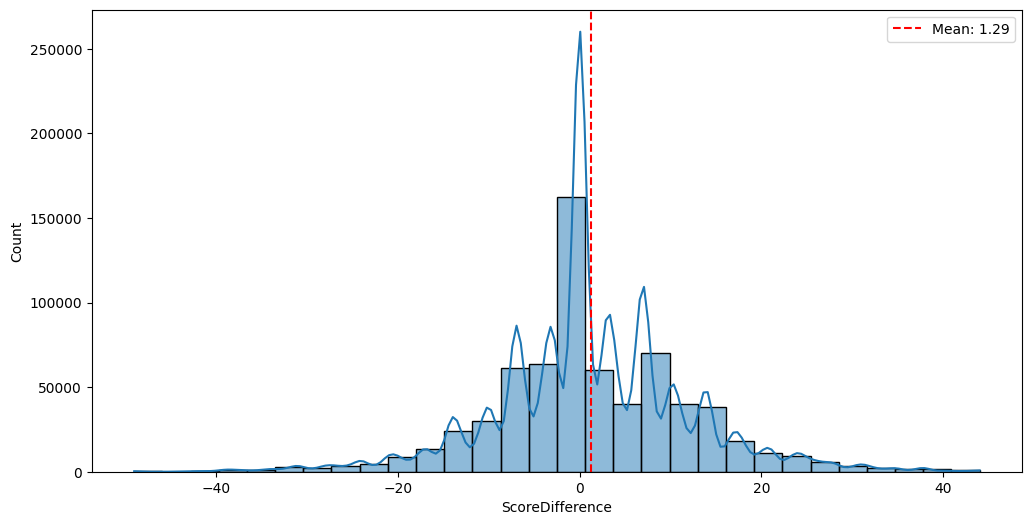

In [ ]:
plt.figure(figsize=(12, 6))

# create a density distribution plot for the Yards columns
sns.histplot(df['ScoreDifference'], bins=30, kde=True)

# Add the line for the mean value
mean_value = df['ScoreDifference'].mean()
plt.axvline(mean_value, color='r', linestyle='--', label=f'Mean: {mean_value:.2f}')

# show the plot
plt.legend()
plt.show()

- **OffenseFormation & OffensePersonnel**: Label Encoding

OffensePersonnel is a more detailed variable that explains the OffenseFormation variable in more information.

In [ ]:
df['OffenseFormation'].value_counts()

OffenseFormation
SINGLEBACK    299728
SHOTGUN       206558
I_FORM        136950
PISTOL         21538
JUMBO          14894
WILDCAT         1694
EMPTY            682
ACE               22
Name: count, dtype: int64

In [ ]:
# Create a label encoder object
label_encoder = LabelEncoder()
# Fit the label encoder to your data
df['OffenseFormation_label'] = label_encoder.fit_transform(df['OffenseFormation'])

# check the result
df['OffenseFormation_label'].value_counts()

OffenseFormation_label
6    299728
5    206558
2    136950
4     21538
3     14894
7      1694
1       682
8        88
0        22
Name: count, dtype: int64

In [ ]:
df['OffensePersonnel'].value_counts()

OffensePersonnel
1 RB, 1 TE, 3 WR               310288
1 RB, 2 TE, 2 WR               155232
2 RB, 1 TE, 2 WR                71764
1 RB, 3 TE, 1 WR                39556
2 RB, 2 TE, 1 WR                34958
                                ...  
6 OL, 3 RB, 0 TE, 1 WR             22
6 OL, 1 RB, 1 TE, 0 WR,2 DL        22
1 RB, 2 TE, 3 WR                   22
6 OL, 1 RB, 1 TE, 1 WR,1 LB        22
1 RB, 3 TE, 0 WR,1 DB              22
Name: count, Length: 61, dtype: int64

In [ ]:
# Create a label encoder object
label_encoder = LabelEncoder()
# Fit the label encoder to your data
df['OffensePersonnel_label'] = label_encoder.fit_transform(df['OffensePersonnel'])

# check the result
df['OffensePersonnel_label'].value_counts()

OffensePersonnel_label
9     310288
13    155232
31     71764
18     39556
33     34958
       ...  
54        22
42        22
14        22
44        22
15        22
Name: count, Length: 61, dtype: int64

- **DefendersInTheBox & DefensePersonnel**: Label Encoding

In [ ]:
df['DefendersInTheBox'].value_counts()

DefendersInTheBox
7.0     279686
6.0     209792
8.0     139370
5.0      22418
9.0      17072
10.0      5038
11.0      4532
4.0       3652
3.0        528
2.0         44
Name: count, dtype: int64

In [ ]:
df['DefensePersonnel'].value_counts()

DefensePersonnel
4 DL, 2 LB, 5 DB          177188
4 DL, 3 LB, 4 DB          173250
3 DL, 4 LB, 4 DB          110418
2 DL, 4 LB, 5 DB           81378
3 DL, 3 LB, 5 DB           74932
2 DL, 3 LB, 6 DB           17336
4 DL, 1 LB, 6 DB           10450
5 DL, 2 LB, 4 DB            7084
4 DL, 4 LB, 3 DB            6490
3 DL, 2 LB, 6 DB            5258
5 DL, 3 LB, 3 DB            3212
1 DL, 4 LB, 6 DB            2200
3 DL, 5 LB, 3 DB            1672
5 DL, 4 LB, 2 DB            1672
6 DL, 3 LB, 2 DB            1408
6 DL, 4 LB, 1 DB            1364
5 DL, 1 LB, 5 DB            1100
1 DL, 5 LB, 5 DB             924
6 DL, 2 LB, 3 DB             880
2 DL, 5 LB, 4 DB             616
1 DL, 3 LB, 7 DB             506
2 DL, 2 LB, 7 DB             418
4 DL, 5 LB, 2 DB             352
5 DL, 5 LB, 1 DB             330
3 DL, 1 LB, 7 DB             286
2 DL, 4 LB, 4 DB, 1 RB       220
1 DL, 4 LB, 5 DB, 1 RB       154
5 DL, 3 LB, 2 DB, 1 OL       154
0 DL, 5 LB, 6 DB             132
0 DL, 4 LB, 7 DB          

In [ ]:
# Create a label encoder object
label_encoder = LabelEncoder()
# Fit the label encoder to your data
df['DefensePersonnel_label'] = label_encoder.fit_transform(df['DefensePersonnel'])

# check the result
df['DefensePersonnel_label'].value_counts()

DefensePersonnel_label
26    177188
27    173250
22    110418
15     81378
19     74932
12     17336
25     10450
34      7084
29      6490
18      5258
36      3212
8       2200
23      1672
38      1672
42      1408
43      1364
33      1100
9        924
41       880
16       616
6        506
10       418
31       352
39       330
17       286
14       220
7        154
35       154
2        132
1        132
5         88
13        66
32        66
37        66
24        66
21        44
3         44
11        44
40        22
0         22
44        22
4         22
20        22
30        22
28        22
Name: count, dtype: int64

- **PlayerHeight**: remove '-' in the rows

In [ ]:
# remove "-" and convert to inches
df['PlayerHeight'] = df['PlayerHeight'].apply(lambda x: 12*int(x.split('-')[0])+int(x.split('-')[1]))

# check the result
df['PlayerHeight'].unique()

array([72, 75, 74, 71, 78, 81, 76, 73, 70, 77, 79, 69, 68, 67, 80, 66])

- **Position**: recoding this feature

In [ ]:
df['Position'].unique()

array(['SS', 'DE', 'ILB', 'FS', 'CB', 'DT', 'WR', 'TE', 'T', 'QB', 'RB',
       'G', 'C', 'OLB', 'NT', 'FB', 'MLB', 'LB', 'OT', 'S', 'OG', 'HB',
       'DB', 'DL', 'SAF'], dtype=object)

In [ ]:
# Create a label encoder object
label_encoder = LabelEncoder()
# Fit the label encoder to your data
df['Position_label'] = label_encoder.fit_transform(df['Position'])

# check the result
df['Position_label'].value_counts()

Position_label
1     74474
24    71494
22    56266
8     54613
5     47220
3     46827
23    44232
15    43333
0     32997
7     32691
18    31370
17    31153
21    26790
10    23029
11    13989
12    13276
13    10753
16     8370
14     4945
6      4799
2      4756
19     2656
4      1134
9       968
20       19
Name: count, dtype: int64

## Dealing with missing data

In [ ]:
# checking missing values by column
df.isnull().sum()

GameId                         0
PlayId                         0
Team                           0
X                              0
Y                              0
S                              0
A                              0
Dis                            0
Orientation                   23
Dir                           28
NflId                          0
DisplayName                    0
JerseyNumber                   0
Season                         0
YardLine                       0
Quarter                        0
GameClock                      0
PossessionTeam                 0
Down                           0
Distance                       0
FieldPosition               8602
HomeScoreBeforePlay            0
VisitorScoreBeforePlay         0
NflIdRusher                    0
OffenseFormation              88
OffensePersonnel               0
DefendersInTheBox             22
DefensePersonnel               0
PlayDirection                  0
TimeHandoff                    0
TimeSnap  

'FieldPosition' could be dropped (done in select columns part)

'StadiumType' : the null values could be replace by the mode（）.

'Turf': the null values could be replace by the mode（）. We will use Turf_dummy column for training the model.

'GameWeather': we could fill the null values with 0.

'Temperature': we could fill the null values with the average temperature.

'Humidity': we could fill the null values with 0.

'WindSpeed': we could fill the null values with 0.

'WindDirection': we could fill the null values/Unknown with 'Calm'. If necessary, we could remove the 'calm' rows. According to the plot, the wind speed for 'Calm' is slow, which could be overlooked.


'Orientation', 'Dir', 'OffenseFormation', 'DefendersInTheBox' the rows which has null value can be dropped because we have enough data.

In [ ]:
df['StadiumType'] = df['StadiumType'].fillna(df['StadiumType'].mode()[0])
df['Turf_dummy'] = df['Turf_dummy'].fillna(df['Turf_dummy'].mode()[0])
df['GameWeather'] = df['GameWeather'].fillna(0)
df['Temperature'] = df['Temperature'].fillna(df['Temperature'].mean())
df['Humidity'] = df['Humidity'].fillna(0)
df['WindSpeed'] = df['WindSpeed'].fillna(0)

# drop the rows which has null value
df = df.dropna(subset=['Orientation', 'Dir', 'OffenseFormation', 'DefendersInTheBox'])

# check the work
df.isnull().sum()

GameId                       0
PlayId                       0
Team                         0
X                            0
Y                            0
S                            0
A                            0
Dis                          0
Orientation                  0
Dir                          0
NflId                        0
DisplayName                  0
JerseyNumber                 0
Season                       0
YardLine                     0
Quarter                      0
GameClock                    0
PossessionTeam               0
Down                         0
Distance                     0
FieldPosition             8602
HomeScoreBeforePlay          0
VisitorScoreBeforePlay       0
NflIdRusher                  0
OffenseFormation             0
OffensePersonnel             0
DefendersInTheBox            0
DefensePersonnel             0
PlayDirection                0
TimeHandoff                  0
TimeSnap                     0
Yards                        0
PlayerHe

In [ ]:
# check the shape of dataset after data cleaning
df.shape

(682034, 58)

In [ ]:
df.columns

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'Yards', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Team_dummy',
       'Turf_dummy', 'WindDirection_label', 'Possesion_Team_New',
       'ScoreDifference', 'OffenseFormation_label', 'OffensePersonnel_label',
       'DefensePersonnel_label', 'Position_label'],
      dtype='object')

# EDA

Here, we will discuss which variables are important to us and how we will use them.



- **Target varible**: **Yards**




- **What we want to keep**:
GameId, PlayId, Team, X, Y ,S ,A, Dis, Orientation, Dir, NflId, DisplayName, YardLine, Quarter, GameClock(use for Stats analytics), Down(*), Distance(*), FieldPosition&PossessionTeam(use for Stats analytics), HomeScoreBeforePlay, VisitorScoreBeforePlay, NflIdRusher, OffenseFormation, OffensePersonnel, DefendersInTheBox, DefensePersonnel, PlayerHeight, PlayerWeight, Position, HomeTeamAbbr, StadiumType, Turf, GameWeather, Temperature, Humidity, WindSpeed.




- **What we don't use**:
jersey number, season, PlayerBirthDate(it could be converted into rough age), PlayerCollegeName(use for Stats analytics if necessary), HomeTeamAbbr & VisitorTeamAbbr(we already keep the FieldPosition variable), Week, Stadium, Location, TimeHandoff&TimeSnap(use for Stats analytics if necessary), FieldPosition, PlayDirection, WindDirection.



In [ ]:
selected_columns = ['X', 'Y', 'S', 'A', 'Dis', 'Orientation', 'Dir', 'YardLine', 'Quarter',
                    'Down', 'Distance',
                    'DefendersInTheBox', 'OffenseFormation_label', 'OffensePersonnel_label', 'DefensePersonnel_label',
                    'Possesion_Team_New', 'ScoreDifference', 'Team_dummy',
                    'PlayerHeight','PlayerWeight', 'GameWeather', 'Temperature',
                    'Humidity', 'WindSpeed', 'WindDirection_label', 'Turf_dummy', 'StadiumType',
                    'Yards', #'Position',
                    'Position_label',
                    ]

new_df = df[selected_columns]
new_df.shape

(682034, 29)

- Distribution of target variable

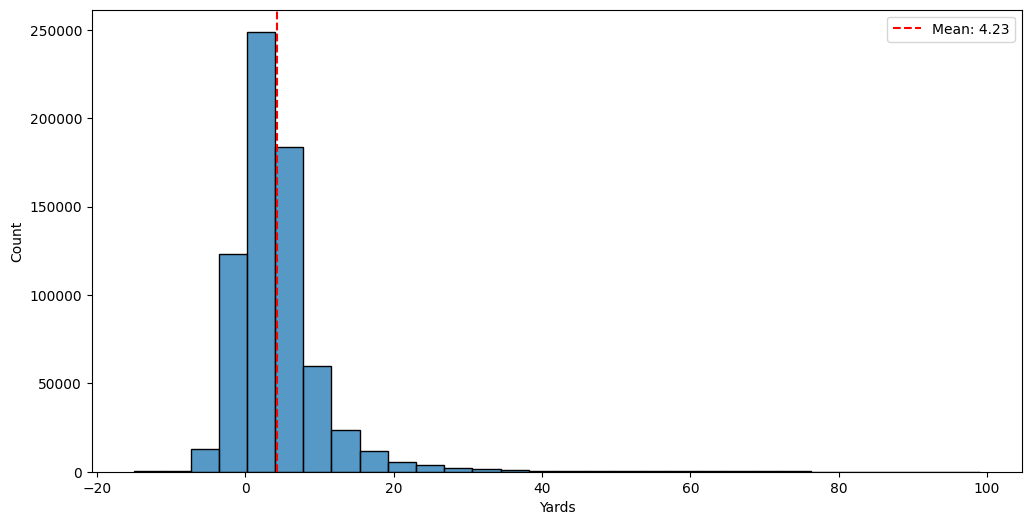

In [ ]:
plt.figure(figsize=(12, 6))

# create a density distribution plot for the Yards columns
sns.histplot(df['Yards'], bins=30)

# Add the line for the mean value
mean_value = df['Yards'].mean()
plt.axvline(mean_value, color='r', linestyle='--', label=f'Mean: {mean_value:.2f}')

# show the plot
plt.legend()
plt.show()

In [ ]:
np.mean(new_df['Yards']>40)

0.004721172258274514

- Correlation

In [ ]:
# Calculate correlations
new_df.corr()['Yards'].sort_values()

DefendersInTheBox        -0.104798
DefensePersonnel_label   -0.046470
OffensePersonnel_label   -0.037908
Down                     -0.023501
Temperature              -0.008747
PlayerWeight             -0.008479
PlayerHeight             -0.007786
Quarter                  -0.004888
Humidity                 -0.004446
ScoreDifference          -0.002340
WindSpeed                -0.002016
Y                        -0.001864
Position_label           -0.001099
Orientation              -0.000226
Team_dummy               -0.000016
Dir                       0.000500
Dis                       0.001856
X                         0.002232
S                         0.003399
Turf_dummy                0.003556
StadiumType               0.003684
Possesion_Team_New        0.004101
GameWeather               0.006378
WindDirection_label       0.013075
OffenseFormation_label    0.017324
A                         0.019980
YardLine                  0.066511
Distance                  0.070650
Yards               

it seems that our target variables has very low correlation with our features.

- KMeans

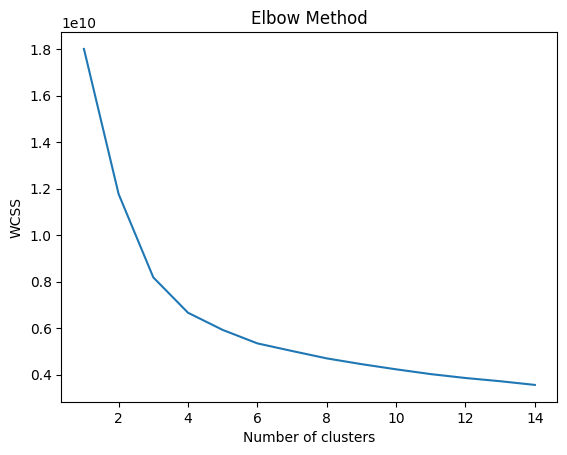

In [ ]:
from sklearn.cluster import KMeans
X = new_df.drop(['Yards'],axis=1)
y = new_df['Yards']

wcss = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 15), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') # Within cluster sum of squares
plt.show()

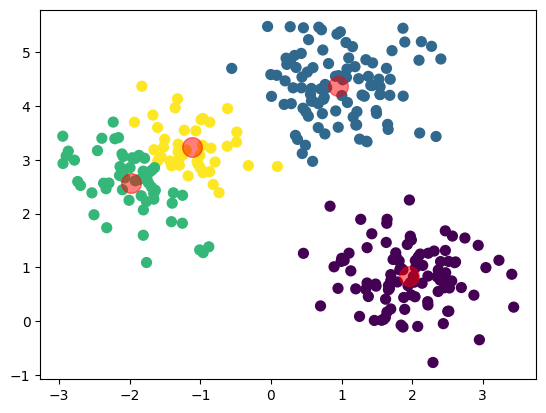

In [ ]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=3, cluster_std=0.60, random_state=0)

kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5)
plt.show()

- PCA

In [ ]:
from sklearn.preprocessing import scale
from sklearn import decomposition

X = scale(new_df.drop(['Yards'],axis=1))
y = new_df['Yards']

pca = decomposition.PCA(n_components=3)
X = pca.fit_transform(X)

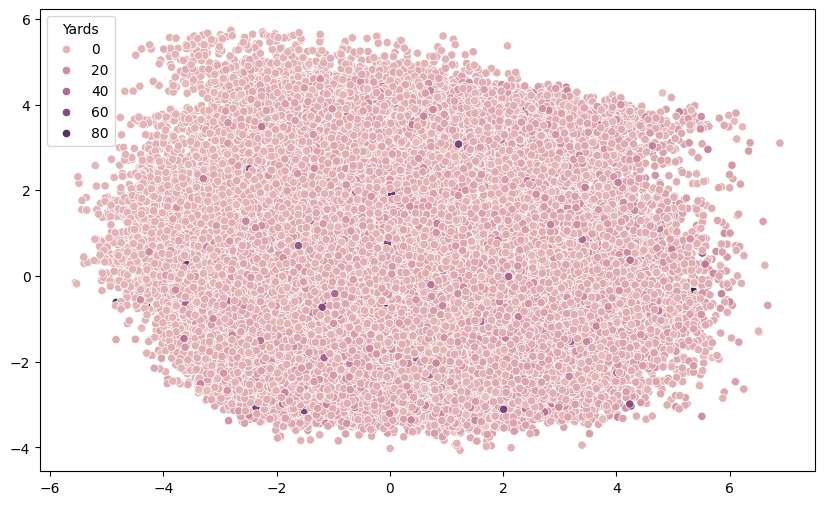

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=X[:,0],y=X[:,1],hue=y)
plt.show()

- ScatterPlot

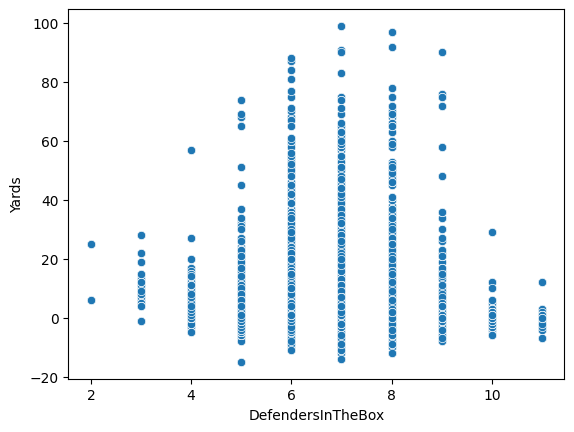

In [ ]:
sns.scatterplot(x="DefendersInTheBox", y="Yards", data=new_df)
plt.show()

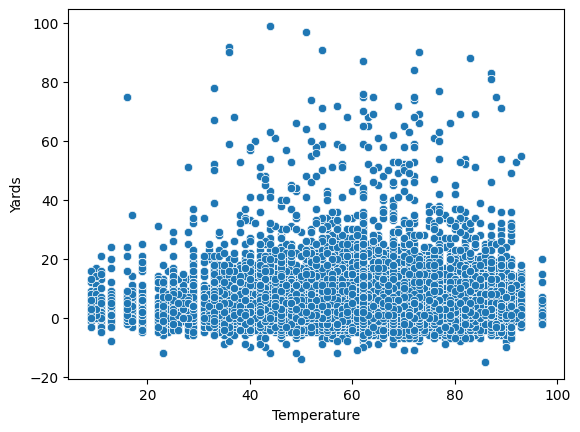

In [ ]:
sns.scatterplot(x="Temperature", y="Yards", data=new_df)
plt.show()

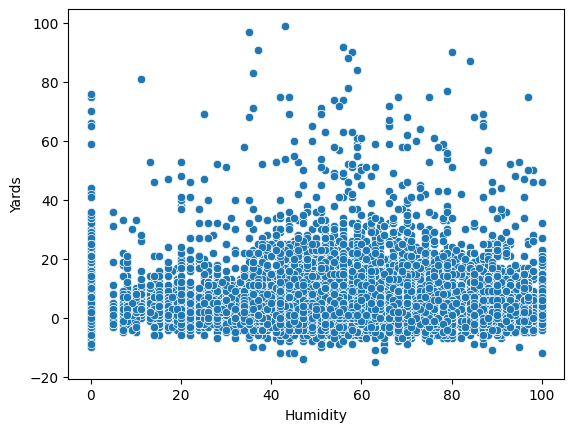

In [ ]:
sns.scatterplot(x="Humidity", y="Yards", data=new_df)
plt.show()

# Modeling
Because the rows represent each player in each play, there is a lot of duplicate information. We'd like to sample the data in order to run the model faster since the dataset is too large, sample data is enough to capture the feature of whole data


In [ ]:
new_df =  new_df.sample(frac=0.5, random_state=333)

# check the shape of the selected dataset
print(new_df.shape)
new_df.head()

(341017, 29)


,X,Y,S,A,Dis,Orientation,Dir,YardLine,Quarter,Down,...,PlayerWeight,GameWeather,Temperature,Humidity,WindSpeed,WindDirection_label,Turf_dummy,StadiumType,Yards,Position_label
254913,109.03,20.89,0.62,0.24,0.20,331.96,7.70,1,1,4,...,305,-3.0,11.0,80.0,3.0,8,1.0,1.0,-1,22
618353,66.37,31.74,2.87,1.30,0.29,230.09,333.95,43,3,2,...,311,0.0,68.0,70.0,0.0,0,1.0,0.0,1,0
375089,64.77,29.97,0.75,3.41,0.14,218.56,74.81,45,1,2,...,313,-1.0,82.0,39.0,1.0,7,1.0,1.0,8,5
400855,67.35,45.57,3.74,5.34,0.35,83.08,332.53,41,3,2,...,196,0.0,69.0,15.0,16.0,3,1.0,1.0,2,1
305872,43.89,30.33,2.67,0.69,0.29,176.23,168.69,34,2,3,...,380,0.0,68.0,70.0,0.0,0,1.0,0.0,-1,22


In [ ]:
#splitting the dataset into features and target variable
X = new_df.drop('Yards', axis=1) # we don't need to use 'Position' here since we already had 'Position_label'
y = new_df['Yards']

#splitting the data into train data and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=102030)

# check the shape
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(272813, 28)
(272813,)
(68204, 28)
(68204,)


## Linear Regression

In [ ]:
# fit the logistic regression
lm = LinearRegression()
lm.fit(X_train, y_train)

# predict on the test data
y_pred = lm.predict(X_test)

# evaluating the model
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared = False)}\n MAE: {mean_absolute_error(y_test, y_pred)} \n R2: {r2_score(y_test, y_pred)}")

RMSE: 6.284024963008465
 MAE: 3.7359650364172983 
 R2: 0.01721907712516857


In [ ]:
pd.DataFrame({"Variables":X_train.columns, "Coef":lm.coef_})

,Variables,Coef
0,X,0.000172
1,Y,-0.003199
2,S,-0.010296
3,A,0.080482
4,Dis,-0.117971
5,Orientation,-0.000060
6,Dir,0.000018
7,YardLine,0.023334
8,Quarter,-0.005701
9,Down,-0.031110


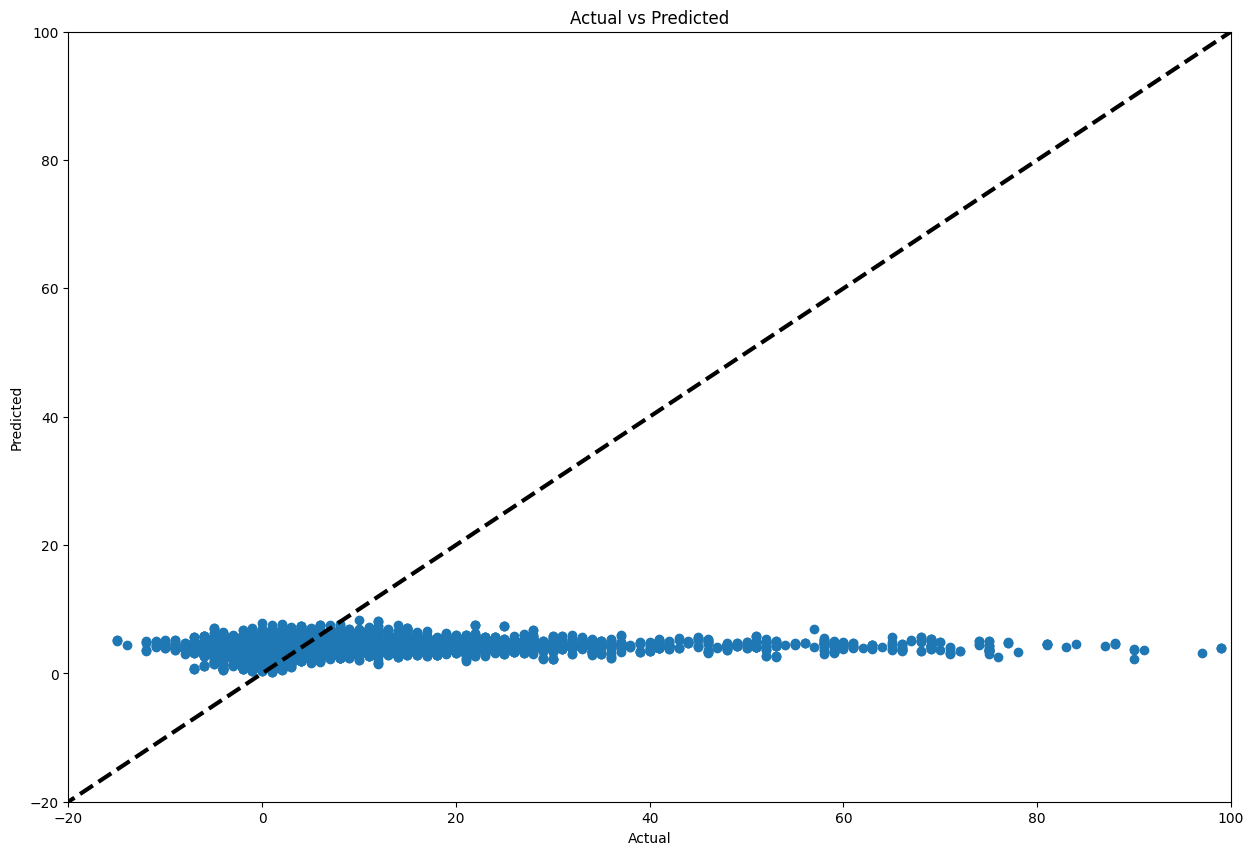

In [ ]:
# actual vs predicted scatterplot
plt.figure(figsize = [15, 10])
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False) # 45 degree line
plt.xlim(-20, 100)
plt.ylim(-20, 100)
plt.show()

## LASSO Regression

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV

#10-fold CV to choose the best lambda
lasso = LassoCV(cv=10).fit(X_train,y_train)
lasso.fit(X_train,y_train)
y_pred = lasso.predict(X_test)

print(f"RMSE: {mean_squared_error(y_test, y_pred, squared = False)}\n MAE: {mean_absolute_error(y_test, y_pred)} \n R2: {r2_score(y_test, y_pred)}")

RMSE: 6.283956732350995
 MAE: 3.735795896528136 
 R2: 0.01724041867771553


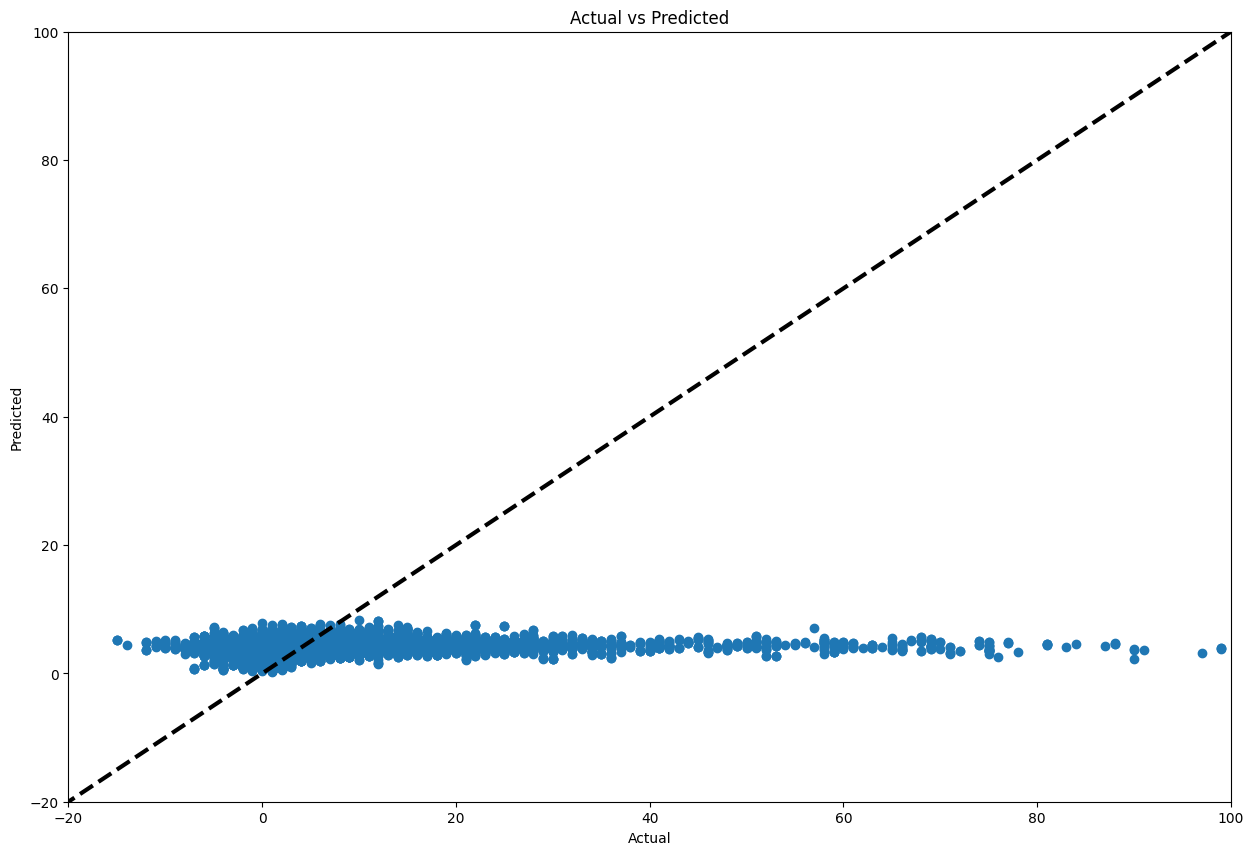

In [ ]:
# actual vs predicted scatterplot
plt.figure(figsize = [15, 10])
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False) # 45 degree line
plt.xlim(-20, 100)
plt.ylim(-20, 100)
plt.show()

## Decision Trees

In [ ]:
# fitting a Decision Tree instance and fitting the data on the training sets
decision_tree = DecisionTreeRegressor()
decision_tree.fit(X_train, y_train)

# Accessing the model's parameters
params = decision_tree.get_params()

# Displaying the parameters
for param, value in params.items():
    print(f"{param}: {value}")

ccp_alpha: 0.0
criterion: squared_error
max_depth: None
max_features: None
max_leaf_nodes: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
random_state: None
splitter: best


In [ ]:
# predictions on the test set
y_pred = decision_tree.predict(X_test)
# evaluating the model
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared = False)}\n MAE: {mean_absolute_error(y_test, y_pred)} \n R2: {r2_score(y_test, y_pred)}")

RMSE: 1.4721029088929227
 MAE: 0.13814439035833675 
 R2: 0.9460666674548308


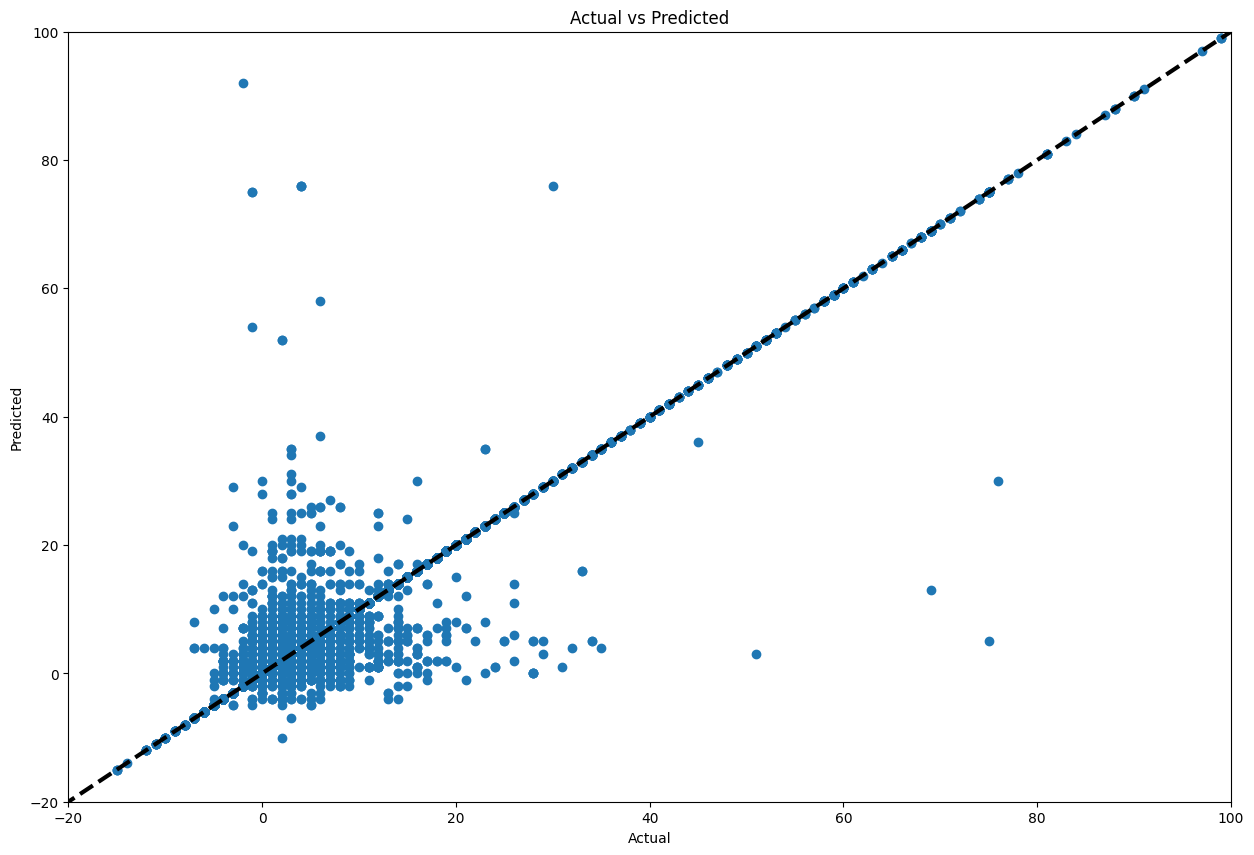

In [ ]:
# actual vs predicted scatterplot

plt.figure(figsize = [15, 10])
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False) # 45 degree line
plt.xlim(-20, 100)
plt.ylim(-20, 100)
plt.show()

In [ ]:
#below is code to find the best parameters for decision tree model
'''
from sklearn.model_selection import GridSearchCV
# Define the parameter grid
param_grid = {
    'max_depth': [30, 50, 100, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', 5, 6 ,7 , None],
    'max_leaf_nodes': [None, 5, 10, 20]
}

# Create a base model
dtree = DecisionTreeRegressor(random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=dtree, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best parameters
print(grid_search.best_params_)
'''

"\nfrom sklearn.model_selection import GridSearchCV\n# Define the parameter grid\nparam_grid = {\n    'max_depth': [30, 50, 100, None],\n    'min_samples_split': [2, 5, 10],\n    'min_samples_leaf': [1, 2, 4],\n    'max_features': ['auto', 'sqrt', 'log2', 5, 6 ,7 , None],\n    'max_leaf_nodes': [None, 5, 10, 20]\n}\n\n# Create a base model\ndtree = DecisionTreeRegressor(random_state=42)\n\n# Instantiate the grid search model\ngrid_search = GridSearchCV(estimator=dtree, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)\n\n# Fit the grid search to the data\ngrid_search.fit(X_train, y_train)\n\n# Best parameters\nprint(grid_search.best_params_)\n"

In [ ]:
tree_depth = []

for i in range(2,28,2):
    decision_tree = DecisionTreeRegressor(max_features=i)
    decision_tree.fit(X_train, y_train)
    y_pred = decision_tree.predict(X_test)
    tree_depth.append(r2_score(y_test, y_pred))

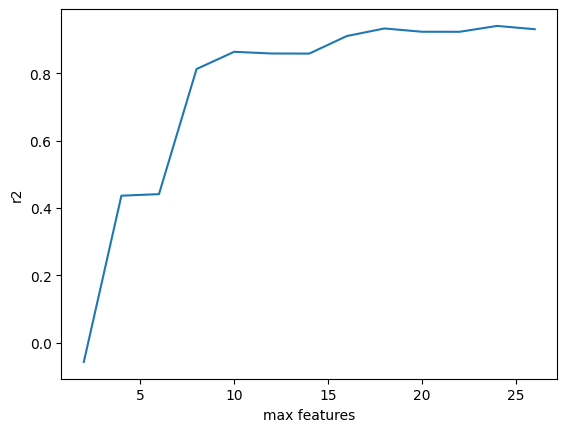

In [ ]:
plt.plot(range(2,28,2), tree_depth)
plt.xlabel('max features')
plt.ylabel('r2')
plt.show()

## Random Forests

In [ ]:
random_forest = RandomForestRegressor(n_estimators=50, random_state=777)
random_forest.fit(X_train, y_train)

# Accessing the model's parameters
params = random_forest.get_params()

# Displaying the parameters
for param, value in params.items():
    print(f"{param}: {value}")

RandomForestRegressor(n_estimators=50, random_state=777)

In [ ]:
# Predict and evaluate on the test set
y_test_pred_rf = random_forest.predict(X_test)
print(f"RMSE: {mean_squared_error(y_test, y_test_pred_rf, squared = False)}\n MAE: {mean_absolute_error(y_test, y_test_pred_rf)} \n R2: {r2_score(y_test, y_test_pred_rf)}")

RMSE: 1.1404258974146406
 MAE: 0.4740531347135065 
 R2: 0.9676320602999926


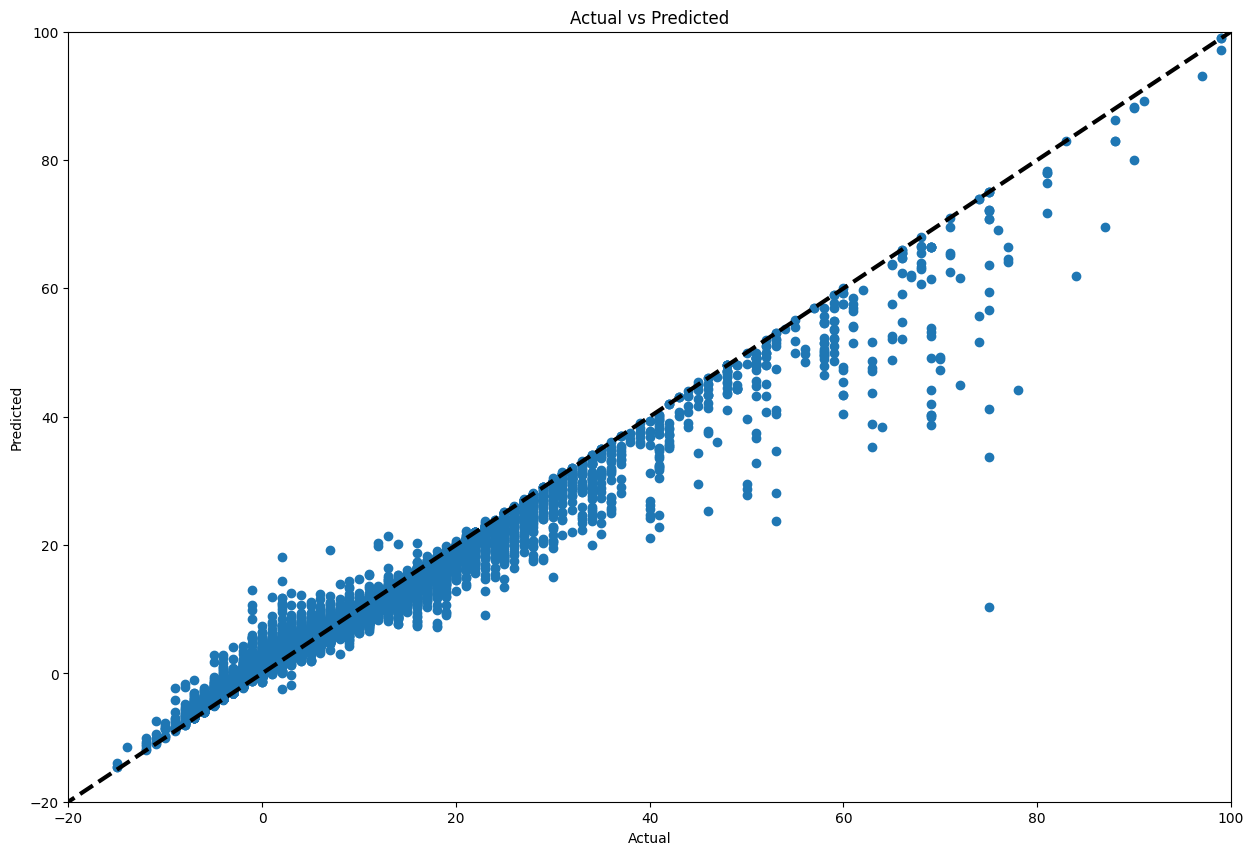

In [ ]:
# actual vs predicted scatterplot
plt.figure(figsize = [15, 10])
plt.scatter(y_test, y_test_pred_rf)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False) # 45 degree line
plt.xlim(-20, 100)
plt.ylim(-20, 100)
plt.show()

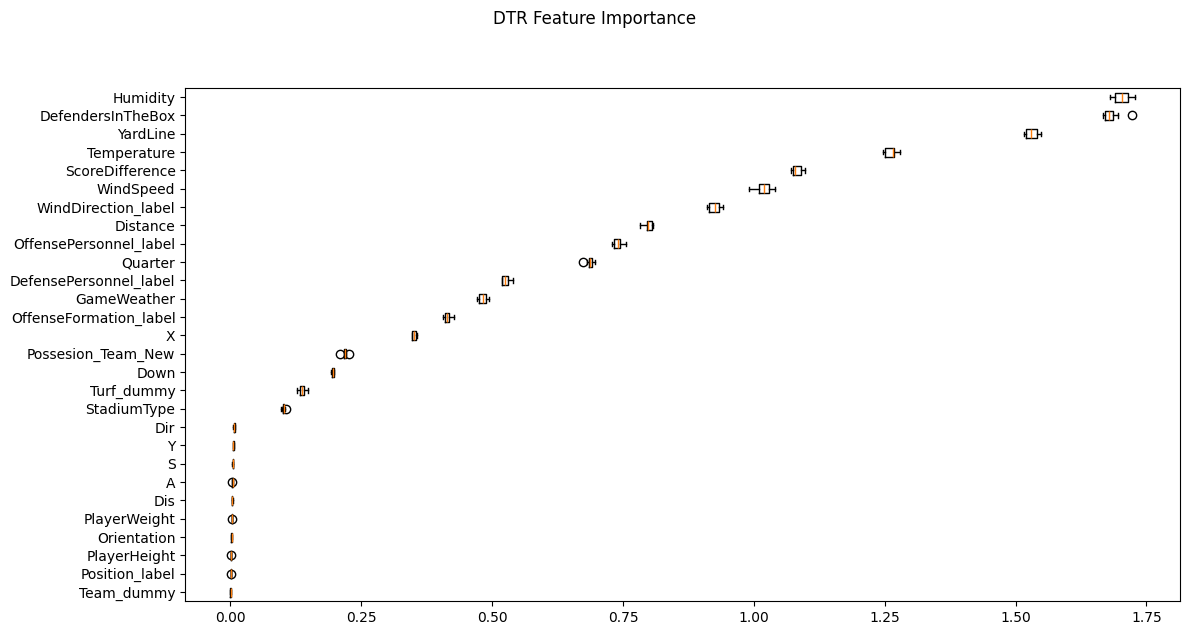

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.inspection import permutation_importance

# let's make this repeatable! all you need to do is assign
# a model object to clf!

clf = decision_tree

result = permutation_importance(clf, X_train, y_train, n_repeats=10,
                                random_state=770)
perm_sorted_idx = result.importances_mean.argsort()

fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))
ax1.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=X_train.columns[perm_sorted_idx])
fig.suptitle('DTR Feature Importance', y=1.05)
fig.tight_layout()
plt.show()

- Players gain more yards when the weather conditions are suitable.

- The higher the humidity, the more yards players gained.

- Saving energy by putting more defense in the box during hot, humid games.

- "A" is seen as important feature when filtering data to only conclude running back.

Here is the graph when filtering data to only conclude running back, we could see the important features are changed.





## Gradient Boosting

In [ ]:
# Creating the Gradient Boosting Regressor model
gb_model = GradientBoostingRegressor(n_estimators=50, max_depth=50, learning_rate=0.1, random_state=778)

# Training the model on the training set
gb_model.fit(X_train, y_train)

# Predict and evaluate on the test set
y_pred = gb_model.predict(X_test)

# evaluating the model
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared = False)}\n MAE: {mean_absolute_error(y_test, y_pred)} \n R2: {r2_score(y_test, y_pred)}")

RMSE: 1.3659977006544237
 MAE: 0.1565654167287202 
 R2: 0.9535612147301623


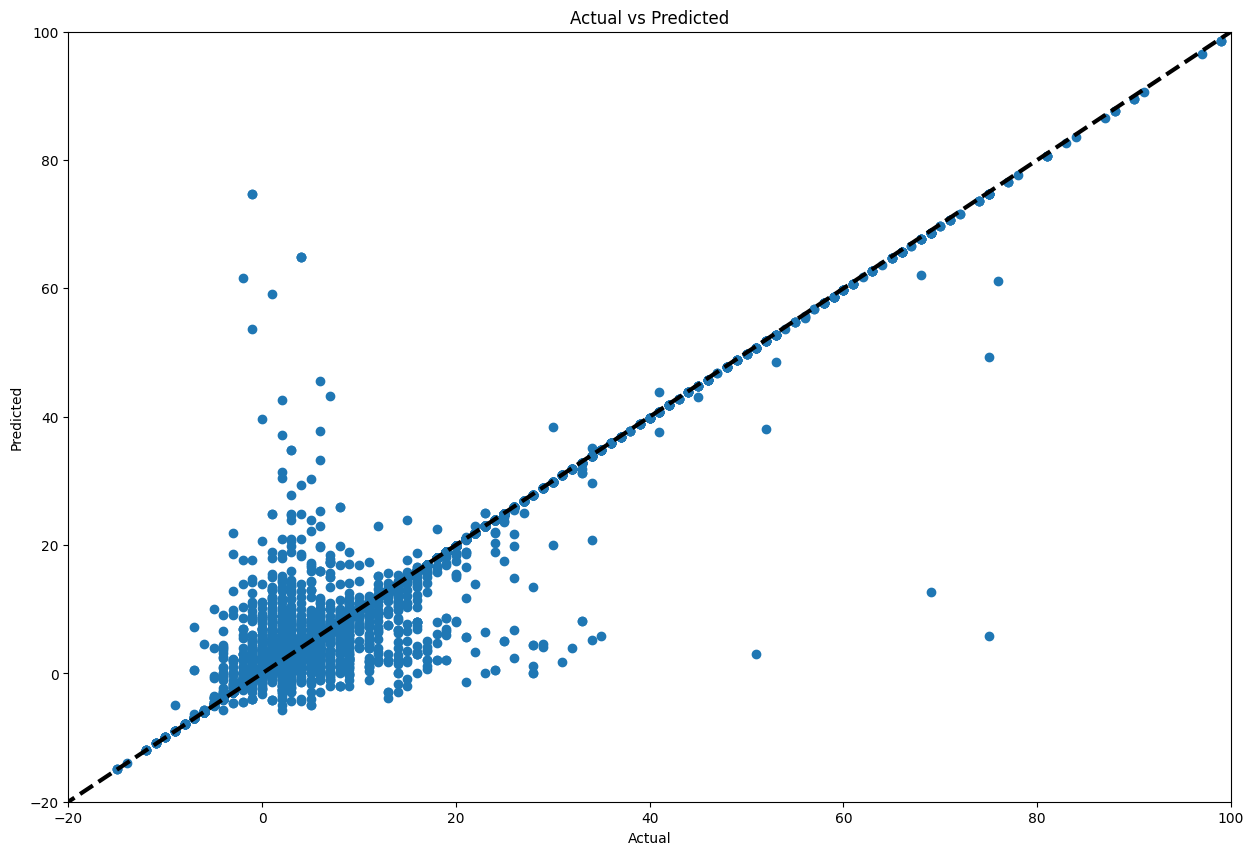

In [ ]:
# actual vs predicted scatterplot
plt.figure(figsize = [15, 10])
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False) # 45 degree line
plt.xlim(-20, 100)
plt.ylim(-20, 100)
plt.show()

## Analysis of modeling

- We get really bad results from linear regression as well as the LASSO regression. First, there is litter **linear** correlation between our independent variables and dependent variable. Second, liinear/lasso regression is not good at dealing with outlier. LASSO regression is a powerful tool to improve the overfitting in linear regression. However, as the linear one did not capture enough information, lasso couldn't improve the accuracy.

- For tree-based method, they return high accuracy. Generally, decision tree is robust, which means it is less sensitive to outlier. We plot how the 'max depth' and 'max feature' affects the performance of model. These tree-based methods can benefit from a large number of the features and big tree. However, it is hard to visualize the result because we have a tree with about 30 layers.


# Analysis & Visualization

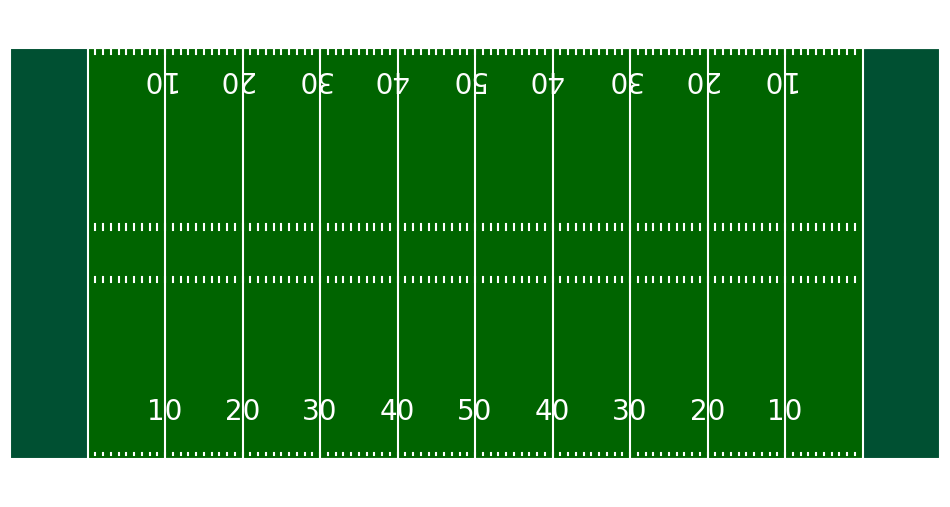

In [ ]:
# code from https://www.kaggle.com/code/pburke1977/nfl-big-data-bowl-plotting-player-position

import matplotlib.pyplot as plt
import matplotlib.patches as patches


def create_football_field(linenumbers=True,
                          endzones=True,
                          highlight_line=False,
                          highlight_line_number=50,
                          highlighted_name='Line of Scrimmage',
                          fifty_is_los=False,
                          figsize=(12, 6.33)):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """
    rect = patches.Rectangle((0, 0), 120, 53.3, linewidth=0.1,
                             edgecolor='r', facecolor='darkgreen', zorder=0)

    fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)

    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='white')
    if fifty_is_los:
        plt.plot([60, 60], [0, 53.3], color='gold')
        plt.text(62, 50, '<- Player Yardline at Snap', color='gold')
    # Endzones
    if endzones:
        ez1 = patches.Rectangle((0, 0), 10, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ez2 = patches.Rectangle((110, 0), 120, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    plt.xlim(0, 120)
    plt.ylim(-5, 58.3)
    plt.axis('off')
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            plt.text(x, 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white')
            plt.text(x - 0.95, 53.3 - 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white', rotation=180)
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)

    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color='white')
        ax.plot([x, x], [53.0, 52.5], color='white')
        ax.plot([x, x], [22.91, 23.57], color='white')
        ax.plot([x, x], [29.73, 30.39], color='white')

    if highlight_line:
        hl = highlight_line_number + 10
        plt.plot([hl, hl], [0, 53.3], color='yellow')
        plt.text(hl + 2, 50, '<- {}'.format(highlighted_name),
                 color='yellow')
    return fig, ax

create_football_field()
plt.show()

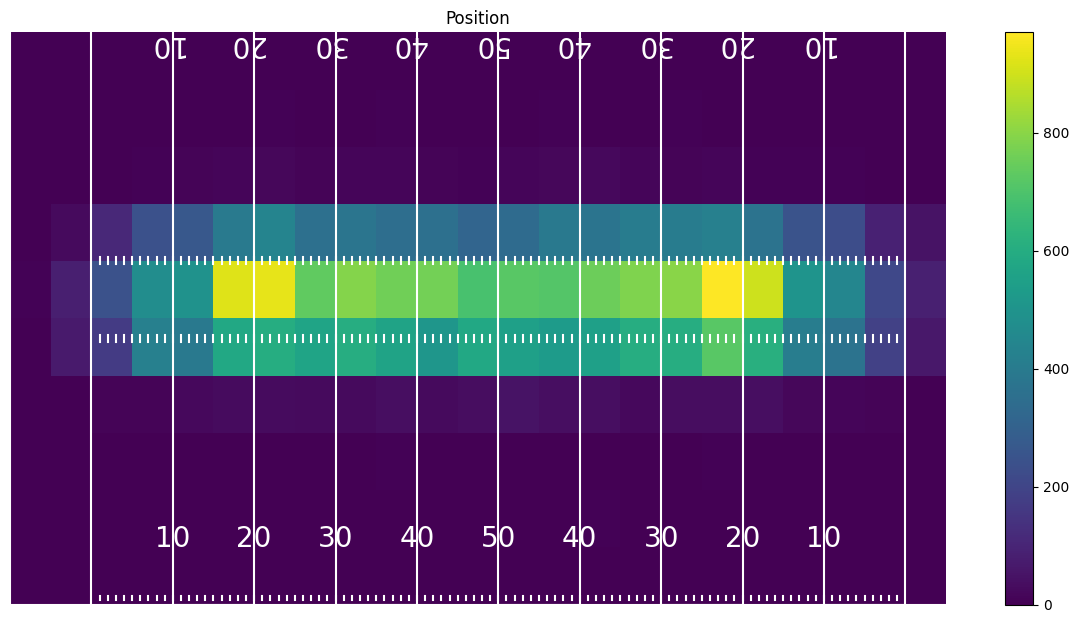

In [ ]:
# Create the football field plot
fig, ax = create_football_field()

# Filter the DataFrame for the specified conditions
temp_df = df.loc[(df['Position'] == 'RB')]

# Use the 'Yards' column as weights for the histogram
weights = temp_df['Yards']

# Create a weighted 2D histogram on the ax object
hb = ax.hist2d(temp_df["X"], temp_df["Y"], cmap='viridis', bins=[np.arange(0, 120, 5), np.arange(0, 54, 5)])

# Add colorbar and title
cbar = plt.colorbar(hb[3], ax=ax)
cbar.set_label('')
ax.set_title("Position")

# Show the plot
fig.tight_layout()
plt.show()

## Yards vs Defenders In The "Box"

The number of defenders in the box is an important factor of stopping the running in the game. Typically defenses will add more players to this area of the field when they really want to stop a run, this comes at a cost leaving wide recievers less covered.

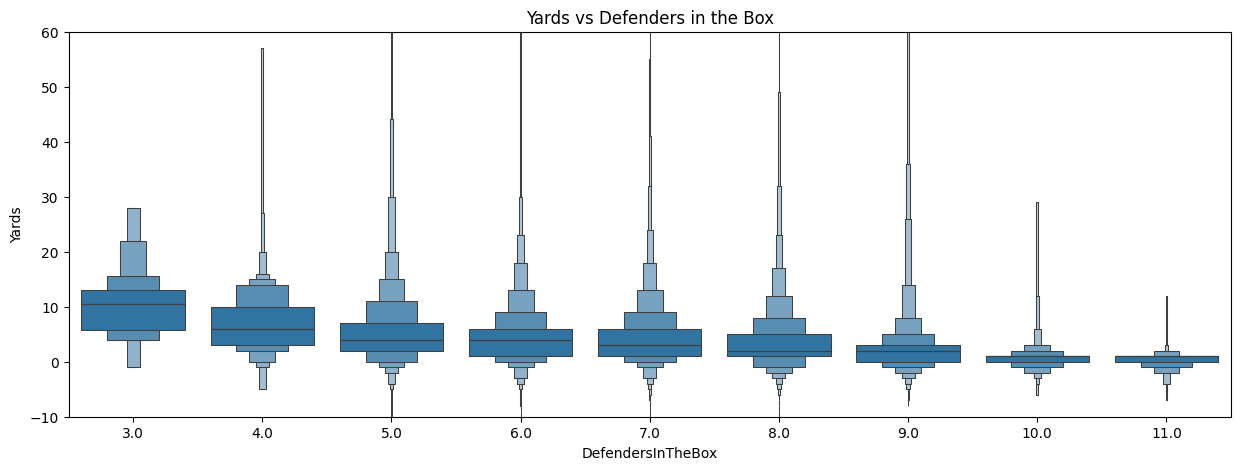

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.set_ylim(-10, 60)
sns.boxenplot(x='DefendersInTheBox',
               y='Yards',
               data=df.query('DefendersInTheBox > 2'), # only shpw the number of defenser is larger than 2
               ax=ax)
plt.title('Yards vs Defenders in the Box')
plt.show()

- We see the density of yards gained when looking at different numbers of defenders in the box.

- This can be used to determine how many defenders to use when an offensive team is X yards away from a first down.


## Which point has the most of a rush?

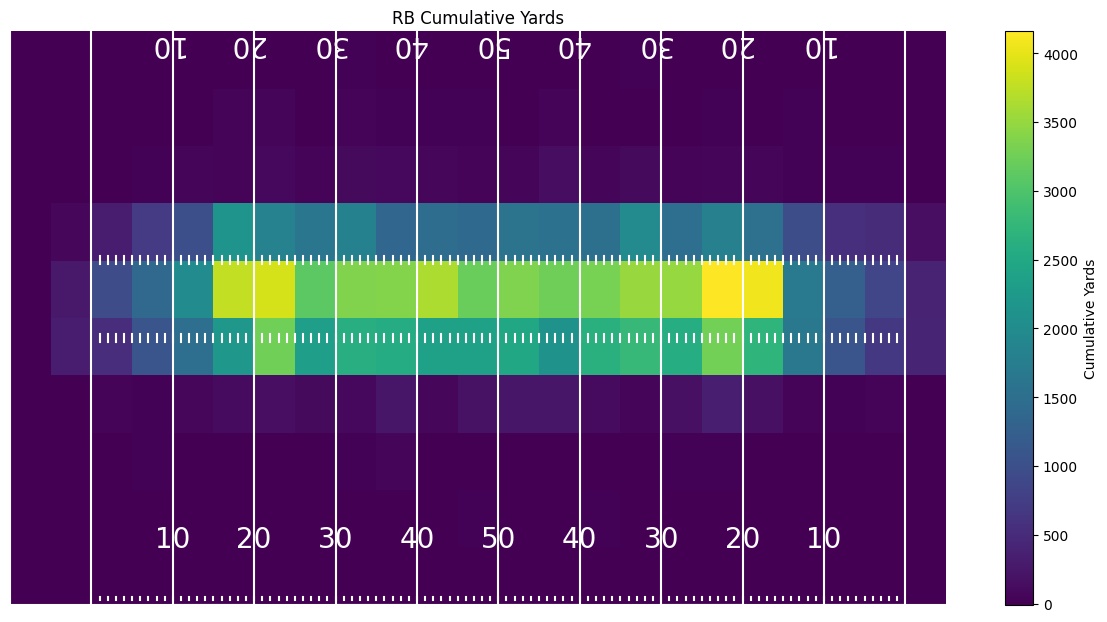

In [ ]:
# Create the football field plot
fig, ax = create_football_field()

# Filter the DataFrame for the specified conditions
temp_df = df.loc[(df['Position'] == 'RB')]

# Use the 'Yards' column as weights for the histogram
weights = temp_df['Yards']

# Create a weighted 2D histogram on the ax object
hb = ax.hist2d(temp_df["X"], temp_df["Y"], weights=weights, cmap='viridis', bins=[np.arange(0, 120, 5), np.arange(0, 54, 5)])

# Add colorbar and title
cbar = plt.colorbar(hb[3], ax=ax)
cbar.set_label('Cumulative Yards')
ax.set_title("RB Cumulative Yards")

# Show the plot
fig.tight_layout()
plt.show()

- We see the density of yards gained when looking at different numbers of defenders in the box.

- This can be used to determine how many defenders to use when an offensive team is X yards away from a first down.


This code will create a weighted 2D histogram on the football field plot, representing the cumulative yards by running backs in the whole field.

In [ ]:
'''
# Create a standard Matplotlib figure and axis
fig, ax = plt.subplots(figsize=(10, 7))

# Filter the DataFrame for 'RB' position
tmp = df.loc[df['Position'] == 'RB', ["Y", "X", "Yards"]].copy()

# Define bins
x_bins = np.arange(0, 120 + 5, 5)  # Up to 125 to include the end point
y_bins = np.arange(0, 55 + 5, 5)   # Up to 60 to include the end point

# Create integer bin labels (one less than the number of bin edges)
x_labels = range(len(x_bins) - 1)
y_labels = range(len(y_bins) - 1)

# Digitize or bin the X and Y data
tmp['x_bin'] = pd.cut(tmp['X'], bins=x_bins, labels=x_labels, right=False)
tmp['y_bin'] = pd.cut(tmp['Y'], bins=y_bins, labels=y_labels, right=False)

# Group by the bins and calculate the mean
grouped = tmp.groupby(['y_bin', 'x_bin'])['Yards'].mean().reset_index()

# Create a pivot table
pivot_table = grouped.pivot(index='y_bin', columns='x_bin', values='Yards')

# Fill NaN values in the pivot table
pivot_table = pivot_table.fillna(0)

# Create a heatmap using seaborn
sns.heatmap(pivot_table, ax=ax, cmap='viridis', cbar_kws={'label': 'Average Yards'})

# Set titles and labels
ax.set_title("Heatmap of Average Yards by Binned X and Y Positions")
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")

# Adjust layout and show plot
plt.show()
'''

'\n# Create a standard Matplotlib figure and axis\nfig, ax = plt.subplots(figsize=(10, 7))\n\n# Filter the DataFrame for \'RB\' position\ntmp = df.loc[df[\'Position\'] == \'RB\', ["Y", "X", "Yards"]].copy()\n\n# Define bins\nx_bins = np.arange(0, 120 + 5, 5)  # Up to 125 to include the end point\ny_bins = np.arange(0, 55 + 5, 5)   # Up to 60 to include the end point\n\n# Create integer bin labels (one less than the number of bin edges)\nx_labels = range(len(x_bins) - 1)\ny_labels = range(len(y_bins) - 1)\n\n# Digitize or bin the X and Y data\ntmp[\'x_bin\'] = pd.cut(tmp[\'X\'], bins=x_bins, labels=x_labels, right=False)\ntmp[\'y_bin\'] = pd.cut(tmp[\'Y\'], bins=y_bins, labels=y_labels, right=False)\n\n# Group by the bins and calculate the mean\ngrouped = tmp.groupby([\'y_bin\', \'x_bin\'])[\'Yards\'].mean().reset_index()\n\n# Create a pivot table\npivot_table = grouped.pivot(index=\'y_bin\', columns=\'x_bin\', values=\'Yards\')\n\n# Fill NaN values in the pivot table\npivot_table = piv

##  New England players Analytics - whole team

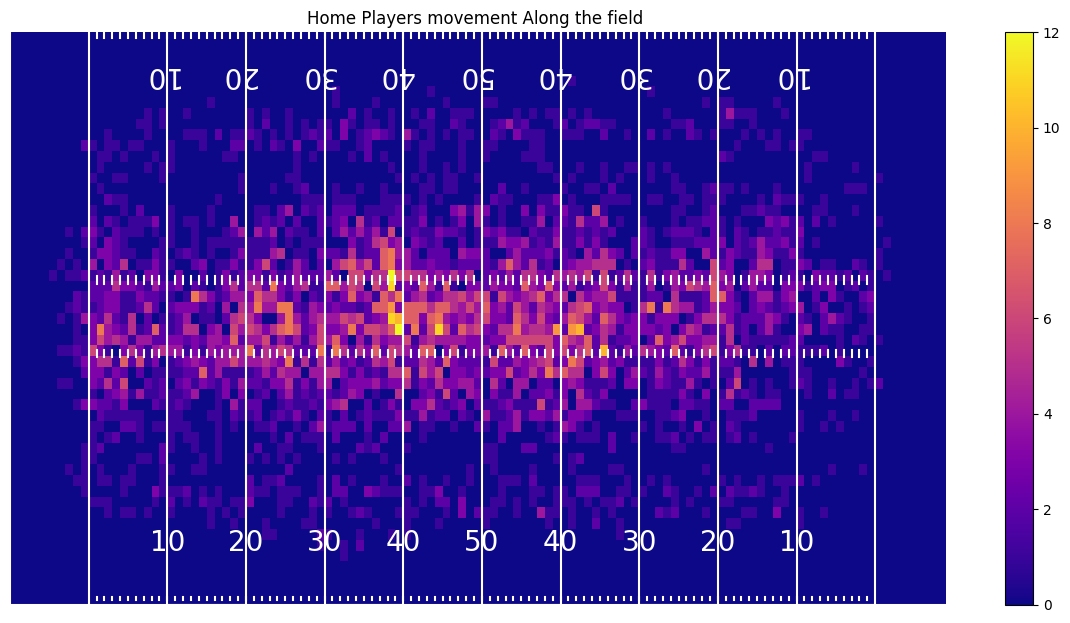

In [ ]:
fig, ax = create_football_field()
temp_df=df.loc[(df["Quarter"]==4) & (df['HomeTeamAbbr'] =='NE')] # here we could see the the frequency of RB position in the Quarter 4
temp_df=temp_df[['X','Y']]

plt.hist2d(temp_df["X"],temp_df["Y"], cmap='plasma', bins=[np.arange(0, 120, 1), np.arange(0, 54, 1)])
plt.colorbar()
plt.title("Home Players movement Along the field ")
fig.tight_layout()
plt.show()

 # the gradient color represents the frequency of data points in different areas of the plot.
 # Here refers to the player's position on the field.

## New England Rushing Analytics  
Gradient color represents the cumulative sum of the yards gained ('Yard') by the running back (RB) position in Quarter 4 for the 'NE'

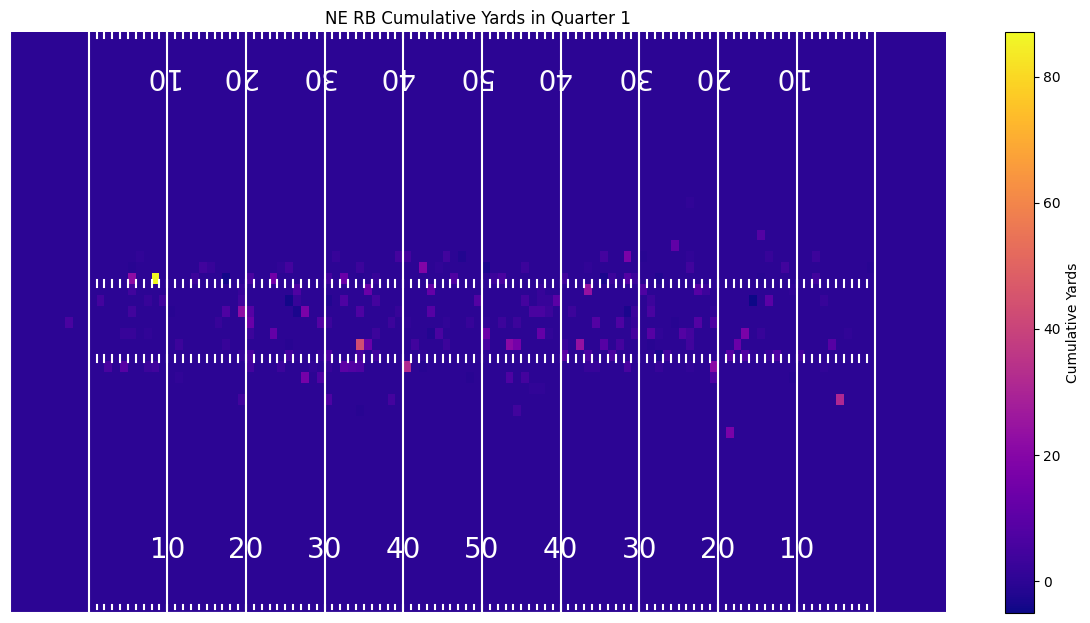

In [ ]:
# Create the football field plot
fig, ax = create_football_field()

# Filter the DataFrame for the specified conditions
temp_df = df.loc[(df["Quarter"] == 1) & (df['Position'] == 'RB') & (df['HomeTeamAbbr'] == 'NE')]


# Use the 'Yard' column as weights for the histogram
weights = temp_df['Yards']

# Create a weighted 2D histogram
plt.hist2d(temp_df["X"], temp_df["Y"], weights=weights, cmap='plasma', bins=[np.arange(0, 120, 1), np.arange(0, 54, 1)])

# Add colorbar and title
plt.colorbar(label='Cumulative Yards')
plt.title("NE RB Cumulative Yards in Quarter 1")

# Show the plot
fig.tight_layout()
plt.show()

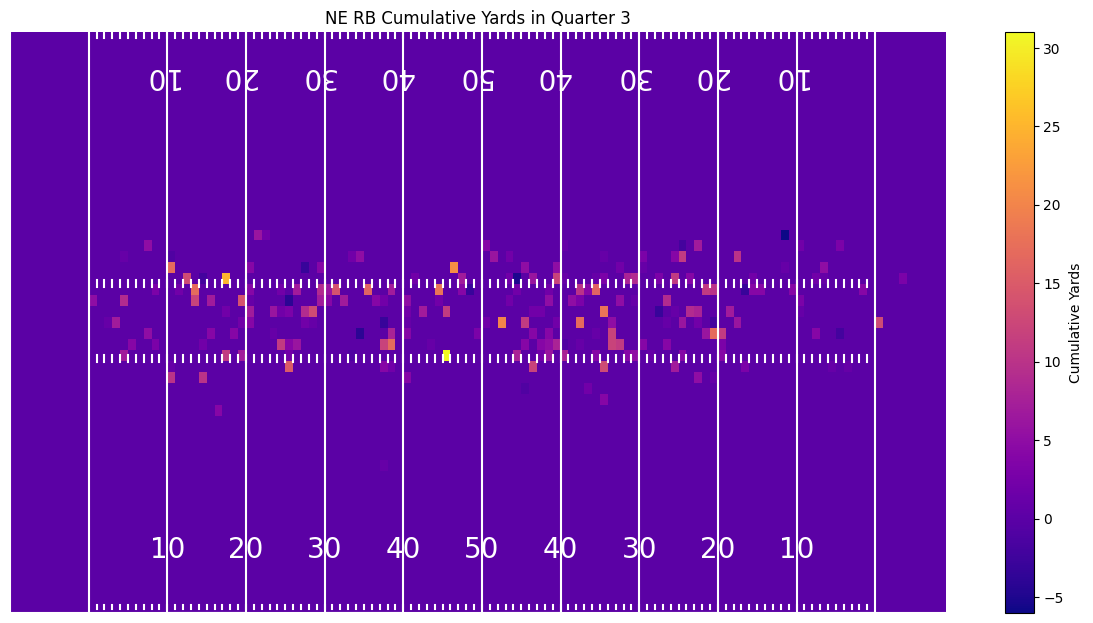

In [ ]:
# Create the football field plot
fig, ax = create_football_field()

# Filter the DataFrame for the specified conditions
temp_df = df.loc[(df["Quarter"] == 3) & (df['Position'] == 'RB') & (df['HomeTeamAbbr'] == 'NE')]


# Use the 'Yard' column as weights for the histogram
weights = temp_df['Yards']

# Create a weighted 2D histogram
plt.hist2d(temp_df["X"], temp_df["Y"], weights=weights, cmap='plasma', bins=[np.arange(0, 120, 1), np.arange(0, 54, 1)])

# Add colorbar and title
plt.colorbar(label='Cumulative Yards')
plt.title("NE RB Cumulative Yards in Quarter 3")

# Show the plot
fig.tight_layout()
plt.show()

In Quater 3, NE typically has more rushing to gain yards compared to Quater 1,2 or 4. Now, we want to see the Positions of QB and RB on the Field in the Quarter 3

- You see that the Patriots tend to run the ball more often in the 3rd Quarter.

- Trends like this can be used to form educated guesses on play types to format defenses or pick who to bet on to score at certain points of the game.


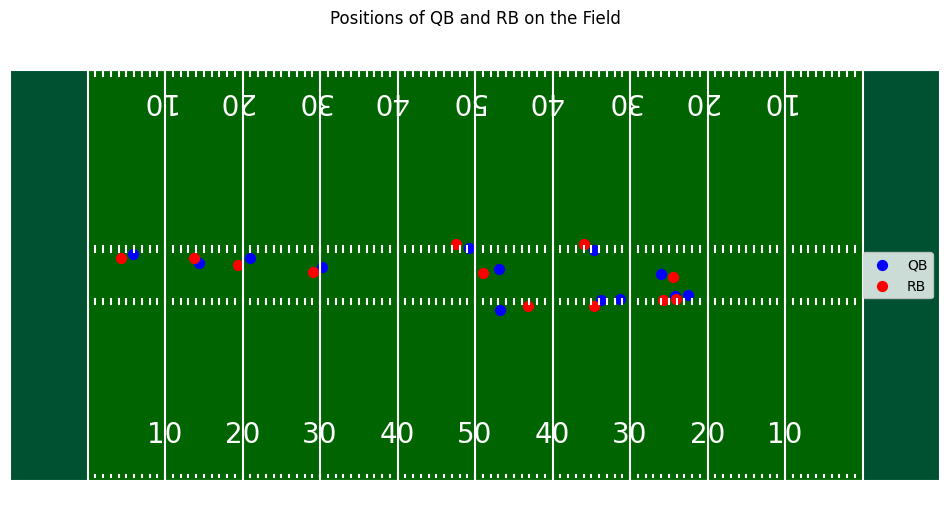

In [ ]:
# Create the football field plot
fig, ax = create_football_field()

# Filter the DataFrame for QB and RB positions

tmp_df = df.loc[(df['GameId'] == 2018093006) & (df["Quarter"] == 3) & (df['HomeTeamAbbr'] == 'NE')]

qb_df = tmp_df.loc[df['Position'] == 'QB']
rb_df = tmp_df.loc[df['Position'] == 'RB']

# Plotting the QB positions
qb_df.plot(x='X', y='Y', kind='scatter', ax=ax, color='blue', s=50, label='QB')

# Plotting the RB positions
rb_df.plot(x='X', y='Y', kind='scatter', ax=ax, color='red', s=50, label='RB')

# Add title and legend
plt.title("Positions of QB and RB on the Field")
plt.legend()

# Show the plot
plt.show()

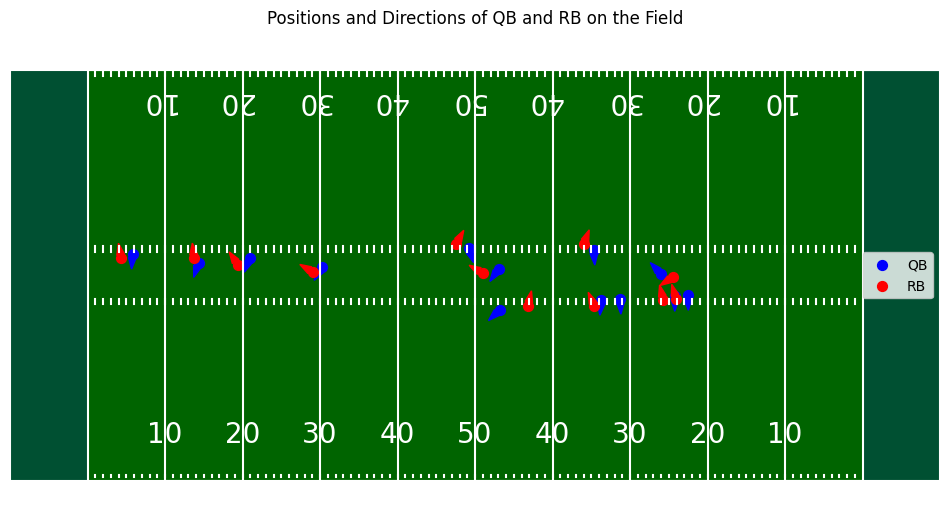

In [ ]:
# Create the football field plot
fig, ax = create_football_field()

# Filter the DataFrame for QB and RB positions in a specific game, quarter, and team
tmp_df = df.loc[(df['GameId'] == 2018093006) & (df["Quarter"] == 3) & (df['HomeTeamAbbr'] == 'NE')]
qb_df = tmp_df.loc[tmp_df['Position'] == 'QB']
rb_df = tmp_df.loc[tmp_df['Position'] == 'RB']

# Function to plot positions and directions
def plot_positions_and_directions(df, ax, color, label):
    # Plotting the player positions
    df.plot(x='X', y='Y', kind='scatter', ax=ax, color=color, s=50, label=label)

    # Adding direction arrows
    for _, row in df.iterrows():
        # Convert direction from degrees to radians
        radians = np.deg2rad(row['Dir'])
        # Calculate the arrow direction
        dx = np.cos(radians) * 2  # Adjust arrow length as needed
        dy = np.sin(radians) * 2  # Adjust arrow length as needed
        # Plot the arrow
        ax.arrow(row['X'], row['Y'], dx, dy, color=color, head_width=1, head_length=1.5, length_includes_head=True)

# Plotting QB and RB positions and directions
plot_positions_and_directions(qb_df, ax, 'blue', 'QB')
plot_positions_and_directions(rb_df, ax, 'red', 'RB')

# Add title and legend
plt.title("Positions and Directions of QB and RB on the Field")
plt.legend()

# Show the plot
plt.show()


- We see here that with a right handed quarterback there is a tendency to hand it off to the right side.

- Defenses can formate themselves to block the left side of the box to anticipate a play going to that side.


Based on our findings and facts

- The right-handedness of most QBs/offenses
- Conventionally, the left side of the defense is the strong side.
- The LDE tends to be a bigger player that can set the edge on the strong side against the TE/RT combo and play the run.
- The RDE tends to be the edge rushing/pursuit talent.


## Exploring  RB player in one specific game
- use ['GameId'] == 2018093006 as example

In [ ]:
temp_df = df.loc[(df['GameId'] == 2018093006) & (df['Position'] == 'RB') & (df['PlayDirection']=='right') & (df['PossessionTeam'] =='NE')]
#temp_df.head(30)

temp_df['PlayDirection'].value_counts()

PlayDirection
right    22
Name: count, dtype: int64

In [ ]:
temp_df.Yards.value_counts()

Yards
 3     6
 1     3
 2     3
 5     2
 22    1
 23    1
 0     1
 7     1
 4     1
 9     1
-2     1
 11    1
Name: count, dtype: int64

In [ ]:
'''
fig, ax = create_football_field()
temp_df.plot(x='X', y='Y', kind='scatter', ax=ax, color='orange', s=30, legend='RB')
plt.title('Game #2018093006 NE RB rushing position - left playdirection')
plt.legend()
plt.show()
'''

"\nfig, ax = create_football_field()\ntemp_df.plot(x='X', y='Y', kind='scatter', ax=ax, color='orange', s=30, legend='RB')\nplt.title('Game #2018093006 NE RB rushing position - left playdirection')\nplt.legend()\nplt.show()\n"

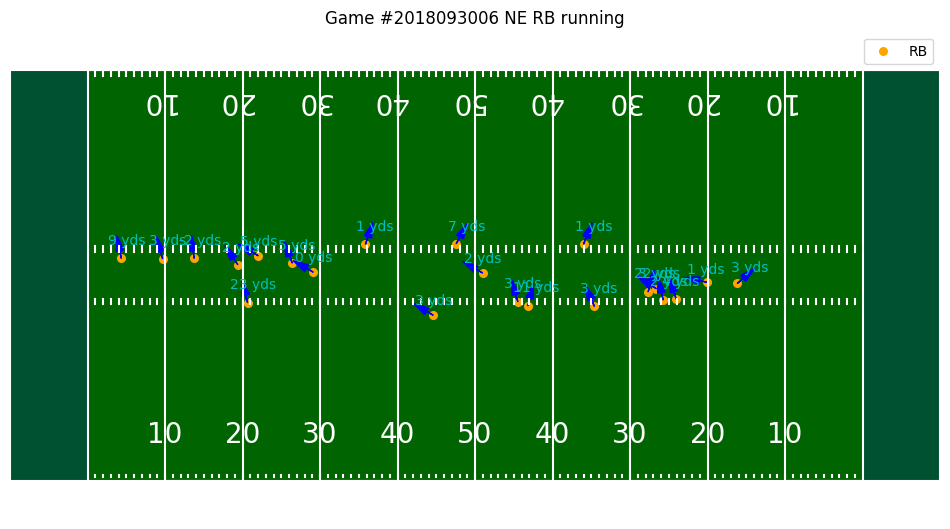

In [ ]:
# Create the football field plot
fig, ax = create_football_field()

# Plotting the players
temp_df.plot(x='X', y='Y', kind='scatter', ax=ax, color='orange', s=30, label='RB')

# Adding arrows to show direction
for _, row in temp_df.iterrows():
    # Calculate the arrow direction
    # Assuming 'Dir' is in degrees, converting it to radians
    radians = np.deg2rad(row['Dir'])
    # Calculate the x and y components of the direction
    dx = np.cos(radians)
    dy = np.sin(radians)
    # Plot the arrow
    ax.arrow(row['X'], row['Y'], dx, dy, color='blue', head_width=1, head_length=2)

    # Annotate yards (assuming you have a 'Yards' column)
    ax.annotate(f"{row['Yards']} yds", (row['X'] + dx, row['Y'] + dy), textcoords="offset points", color = 'c', xytext=(5,5), ha='center')


plt.title('Game #2018093006 NE RB running')
plt.legend()
plt.show()

## Exploring specific player
Tom Brady as example - Player running direction habits

QB is the team's brain, and Tom Brady is a great player, so we'll use him as an example.

In [ ]:
temp_df = df.loc[(df['GameId'] == 2018093006) & (df['DisplayName'] == 'Tom Brady') & (df['PlayDirection'] == 'right') & (df['HomeTeamAbbr'] =='NE')]
temp_df.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,...,WindDirection,Team_dummy,Turf_dummy,WindDirection_label,Possesion_Team_New,ScoreDifference,OffenseFormation_label,OffensePersonnel_label,DefensePersonnel_label,Position_label
313931,2018093006,20180930061075,home,47.20,30.00,4.24,1.67,0.41,341.19,282.65,...,W,1,1.0,8,1,3,6,9,26,17
313975,2018093006,20180930061325,home,36.05,29.45,4.35,0.14,0.43,207.29,271.11,...,W,1,1.0,8,1,10,2,31,27,17
313997,2018093006,20180930061411,home,31.55,27.59,0.99,1.86,0.10,69.55,270.63,...,W,1,1.0,8,1,10,5,9,26,17
314019,2018093006,20180930061539,home,82.72,24.10,0.97,2.15,0.08,64.43,267.04,...,W,1,1.0,8,1,10,5,9,26,17
314063,2018093006,20180930061724,home,21.49,29.49,3.84,1.99,0.37,188.02,265.76,...,W,1,1.0,8,1,17,2,31,27,17


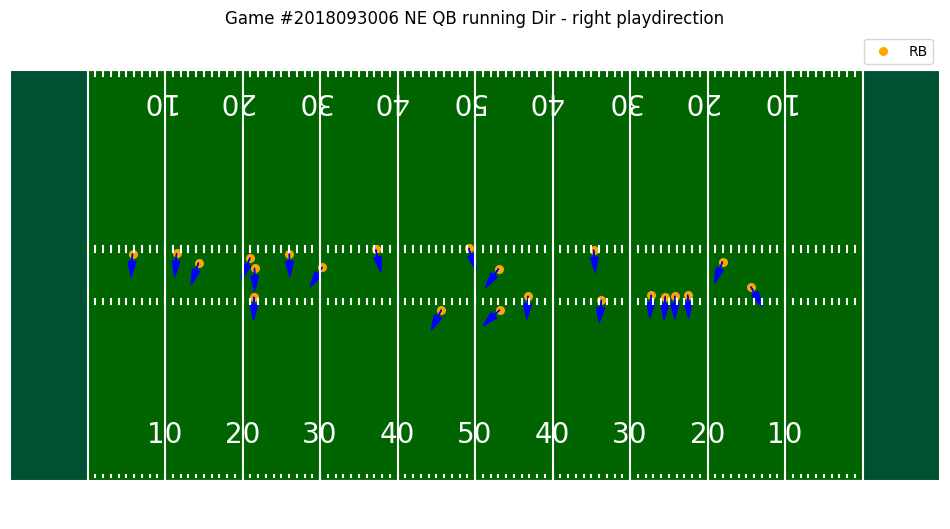

In [ ]:
# Create the football field plot
fig, ax = create_football_field()

# Plotting the players
temp_df.plot(x='X', y='Y', kind='scatter', ax=ax, color='orange', s=30, label='RB')

# Adding arrows to show direction
for _, row in temp_df.iterrows():
    # Calculate the arrow direction
    # Assuming 'Dir' is in degrees, converting it to radians
    radians = np.deg2rad(row['Dir'])
    # Calculate the x and y components of the direction
    dx = np.cos(radians)
    dy = np.sin(radians)
    # Plot the arrow
    ax.arrow(row['X'], row['Y'], dx, dy, color='blue', head_width=1, head_length=2)

    # Annotate yards (assuming you have a 'Yards' column)
    #ax.annotate(f"{row['Yards']} yds", (row['X'] + dx, row['Y'] + dy), textcoords="offset points", color = 'c', xytext=(5,5), ha='center')


plt.title('Game #2018093006 NE QB running Dir - right playdirection')
plt.legend()
plt.show()

In this game, every time Tom Brady completes a handoff, he runs to his right side.

In [ ]:
temp_df = df.loc[(df['Season']== 2018) & (df['DisplayName'] == 'Tom Brady') & (df['PlayDirection'] == 'right') & (df['HomeTeamAbbr'] =='NE')]
temp_df.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,...,WindDirection,Team_dummy,Turf_dummy,WindDirection_label,Possesion_Team_New,ScoreDifference,OffenseFormation_label,OffensePersonnel_label,DefensePersonnel_label,Position_label
268083,2018090905,20180909050051,home,28.94,26.31,4.07,1.31,0.41,290.06,262.29,...,NE,1,1.0,3,1,0,2,33,27,17
268105,2018090905,20180909050072,home,34.48,23.98,1.77,1.86,0.17,123.40,273.86,...,NE,1,1.0,3,1,0,5,9,26,17
268127,2018090905,20180909050093,home,36.09,27.38,1.71,2.02,0.16,98.28,279.46,...,NE,1,1.0,3,1,0,5,9,18,17
268171,2018090905,20180909050184,home,87.89,22.88,3.26,2.15,0.32,221.24,231.77,...,NE,1,1.0,3,1,0,2,31,27,17
268215,2018090905,20180909050430,home,47.83,27.54,4.72,0.74,0.48,235.32,240.54,...,NE,1,1.0,3,1,7,2,31,27,17


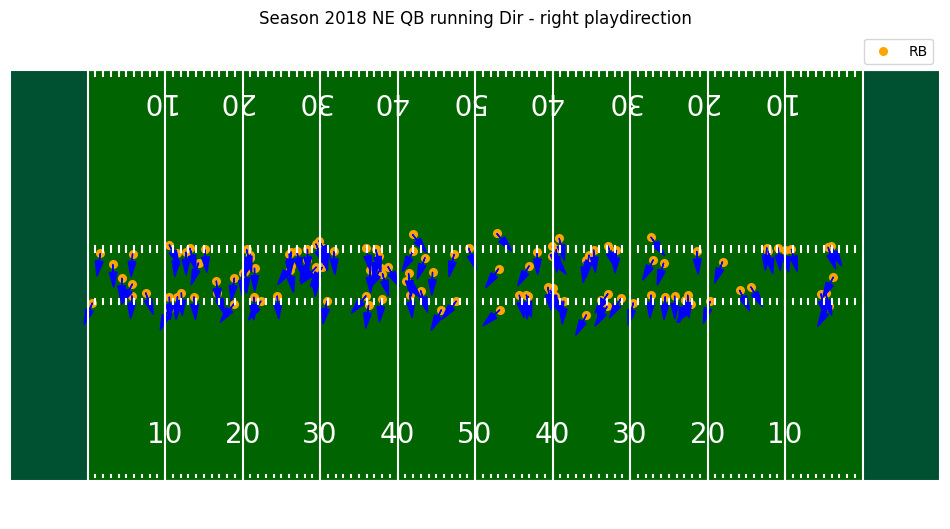

In [ ]:
# Create the football field plot
fig, ax = create_football_field()

# Plotting the players
temp_df.plot(x='X', y='Y', kind='scatter', ax=ax, color='orange', s=30, label='RB')

# Adding arrows to show direction
for _, row in temp_df.iterrows():
    # Calculate the arrow direction
    # Assuming 'Dir' is in degrees, converting it to radians
    radians = np.deg2rad(row['Dir'])
    # Calculate the x and y components of the direction
    dx = np.cos(radians)
    dy = np.sin(radians)
    # Plot the arrow
    ax.arrow(row['X'], row['Y'], dx, dy, color='blue', head_width=1, head_length=2)

    # Annotate yards (assuming you have a 'Yards' column)
    #ax.annotate(f"{row['Yards']} yds", (row['X'] + dx, row['Y'] + dy), textcoords="offset points", color = 'c', xytext=(5,5), ha='center')


plt.title('Season 2018 NE QB running Dir - right playdirection')
plt.legend()
plt.show()

We guessed that Tom Brady has a habit of running to his right after a handoff, and the plot confirmed my skepticism. I filtered and graphed all the rows whose 'playdirection' was 'right' for Tom Brady during the 2018 season.

## Exploring the players' position in the feild for one specific play

In [ ]:
temp_df = df.loc[(df['GameId'] == 2018093006) & (df['PlayDirection'] == 'right')]
temp_df.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,...,WindDirection,Team_dummy,Turf_dummy,WindDirection_label,Possesion_Team_New,ScoreDifference,OffenseFormation_label,OffensePersonnel_label,DefensePersonnel_label,Position_label
313610,2018093006,20180930060142,away,49.59,38.10,4.21,3.08,0.41,81.18,78.14,...,W,0,1.0,8,0,0,5,9,18,24
313611,2018093006,20180930060142,away,48.95,26.77,1.65,0.71,0.15,53.03,35.61,...,W,0,1.0,8,0,0,5,9,18,0
313612,2018093006,20180930060142,away,48.64,24.99,1.43,1.56,0.19,111.28,345.01,...,W,0,1.0,8,0,0,5,9,18,0
313613,2018093006,20180930060142,away,44.33,24.04,0.14,0.72,0.02,123.36,121.38,...,W,0,1.0,8,0,0,5,9,18,17
313614,2018093006,20180930060142,away,48.40,21.66,2.54,2.38,0.24,113.68,3.01,...,W,0,1.0,8,0,0,5,9,18,16


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


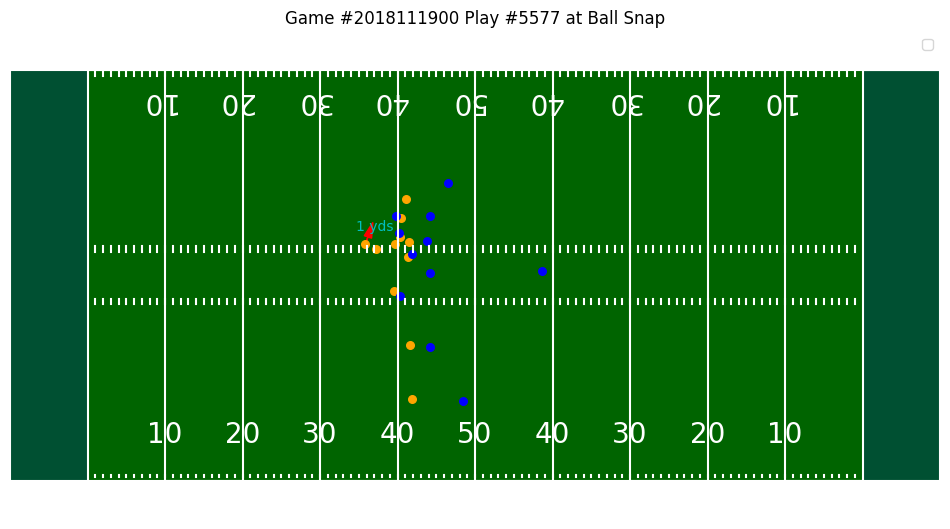

In [ ]:
example_play_home = temp_df.query('PlayId == 20180930061075 and Team == "home"')
example_play_away = temp_df.query('PlayId == 20180930061075 and Team == "away"')
rb_df = example_play_home.loc[example_play_home['Position'] == 'RB']


fig, ax = create_football_field()

# Adding arrows to show direction
for _, row in rb_df.iterrows():
    # Calculate the arrow direction
    # Assuming 'Dir' is in degrees, converting it to radians
    radians = np.deg2rad(row['Dir'])
    # Calculate the x and y components of the direction
    dx = np.cos(radians)
    dy = np.sin(radians)
    # Plot the arrow
    ax.arrow(row['X'], row['Y'], dx, dy, color='red', head_width=1, head_length=2)

    # Annotate yards (assuming you have a 'Yards' column)
    ax.annotate(f"{row['Yards']} yds", (row['X'] + dx, row['Y'] + dy), textcoords="offset points", color = 'c', xytext=(5,5), ha='center')



example_play_home.plot(x='X', y='Y', kind='scatter', ax=ax, color='orange', s=30, legend='Home')
example_play_away.plot(x='X', y='Y', kind='scatter', ax=ax, color='blue', s=30, legend='Away')
plt.title('Game #2018111900 Play #5577 at Ball Snap')
plt.legend()
plt.show()

## Conculsion



Trends/Use Cases

In our project we were able to come to conslusions about multiple offensive team and player trends we gathered in rushing data. These trends support the strategy that many teams use to use more passing plays when further away from the end zone to cover more distance while playing it safer and runnning the ball when closer to the end zone. We were also able to come to conslusions about strategies to use when under certain weather conditions from the data collected on humidity and heat.

The highest correlation we found in the dataset when looking at yards gained was 'defenders in the box'. This is pretty obvious when thinking about it logically but the data obtained about the density of yards gained with different amounts of defenders in the box can provide insights to coaches looking at how many yards they need for a first down, how many defenders are in the box, and then taking the average yards gained from running it with that many defenders and seeing if that will give them a first down.

Another group of trends we looked at was player trends. Knowing how a player prefers to position themselves for one play over another can be useful to defenses predicting a play before it happens. Looking at data from Tom Brady we saw that players tend to develop habits which can be exploited when analyzed correctly.

Team trends are another thing you can look at when looking at sports data and finding trends that certain teams tend to stick with. We were able to come to the conclusion that the NE Patriots are more likely to run the ball in the 3rd quarter than the first. This is extremely insightful information for defenses and also sports fans and bettors who are looking to try to predict or gamble on what will happen next in the game.

To conslude, from this data we were able to find techniques to analyze players, teams, and different plays to help coaches make better decisions on the field and sports bettors better decisions when gambling.